# This is basically a simplified version of ronin_resnet in the main file

## In this file we define the train and test using the resnet model which allows us to understand the code better.

Required packages
1. data global speed
2. Data utils
3. Math utils
4. Metrics
5. resnet_model
6. transformations
7. utils

After successfully simplifying the code, we will try to make the training and evaluation work on the OXIOD dataset or the IDOL dataset
Finally, we will do transfer learning based on our own use case.

In [1]:
#import dependencies

import os
import time
from os import path as osp

import numpy as np
import torch
import json

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader

from data_glob_speed import *
from transformations import *
from metric import compute_ate_rte
from model_resnet1d import *

In [2]:
import argparse
args = argparse.Namespace()

# Hardcoded values for each argument
args.train_list = "/home/jovyan/imu_localisation/ronin/lists/list_train-Copy1.txt"
args.mode = "train"
args.val_list = "/home/jovyan/imu_localisation/ronin/lists/list_val-Copy2.txt"
args.test_list = "/home/jovyan/imu_localisation/ronin/lists/list_test_unseen.txt"
#dataset folder
args.root_dir = "/home/jovyan/localisation_datasets/Ronin_datasets/unseen_subjects_test_set"
args.out_dir = "/home/jovyan/imu_localisation/ronin/output"


args.test_path = None
args.cache_path = None
args.model_path = "/home/jovyan//imu_localisation/ronin/PreTrained_Models/ronin_resnet/ronin_resnet/checkpoint_gsn_latest.pt"

args.dataset = "ronin"
args.max_ori_error = 20.0
args.step_size = 10
args.window_size = 100
args.lr = 1e-04
args.batch_size = 128
args.epochs = 3
args.arch = "resnet18"
args.cpu = False
args.run_ekf = False
args.fast_test = False
args.show_plot = True
args.continue_from = None
args.feature_sigma = 0.00001
args.target_sigma = 0.00001

np.set_printoptions(formatter={'all': lambda x: '{:.6f}'.format(x)})

In [3]:
_input_channel, _output_channel = 6, 2
_fc_config = {'fc_dim': 512, 'in_dim': 7, 'dropout': 0.5, 'trans_planes': 128}
network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [2, 2, 2, 2],
                           base_plane=64, output_block=FCOutputModule, kernel_size=3, **_fc_config)

In [4]:
def run_test(network, data_loader, device, eval_mode=True):
    targets_all = []
    preds_all = []
    if eval_mode:
        network.eval()
    for bid, (feat, targ, _, _) in enumerate(data_loader):
        pred = network(feat.to(device)).cpu().detach().numpy()
        targets_all.append(targ.detach().numpy())
        preds_all.append(pred)
    targets_all = np.concatenate(targets_all, axis=0)
    preds_all = np.concatenate(preds_all, axis=0)
    return targets_all, preds_all

In [5]:
def add_summary(writer, loss, step, mode):
    names = '{0}_loss/loss_x,{0}_loss/loss_y,{0}_loss/loss_z,{0}_loss/loss_sin,{0}_loss/loss_cos'.format(
        mode).split(',')

    for i in range(loss.shape[0]):
        writer.add_scalar(names[i], loss[i], step)
    writer.add_scalar('{}_loss/avg'.format(mode), np.mean(loss), step)

In [6]:
def get_dataset(root_dir, data_list, args, **kwargs):
    mode = kwargs.get('mode', 'train')

    random_shift, shuffle, transforms, grv_only = 0, False, None, False
    if mode == 'train':
        random_shift = args.step_size // 2
        shuffle = True
        transforms = RandomHoriRotate(math.pi * 2)
    elif mode == 'val':
        shuffle = True
    elif mode == 'test':
        shuffle = False
        grv_only = True

    if args.dataset == 'ronin':
        seq_type = GlobSpeedSequence
    dataset = StridedSequenceDataset(
        seq_type, root_dir, data_list, random_shift=random_shift, transform=transforms,
        shuffle=shuffle, grv_only=grv_only)

    global _input_channel, _output_channel
    _input_channel, _output_channel = dataset.feature_dim, dataset.target_dim
    return dataset

def get_dataset_from_list(root_dir, list_path, args, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list, args, **kwargs)


In [8]:
def train(args, **kwargs):
    # Loading data
    start_t = time.time()
    train_dataset = get_dataset_from_list(args.root_dir, args.train_list, args, mode='train')
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    end_t = time.time()
    print('Training set loaded. Feature size: {}, target size: {}. Time usage: {:.3f}s'.format(
        train_dataset.feature_dim, train_dataset.target_dim, end_t - start_t))
    
    val_dataset, val_loader = None, None
    if args.val_list is not None:
        val_dataset = get_dataset_from_list(args.root_dir, args.val_list, args, mode='val')
        val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)
    device = torch.device('cuda:0' if torch.cuda.is_available() and not args.cpu else 'cpu')

    summary_writer = None
    
    if args.out_dir is not None:
        if not osp.isdir(args.out_dir):
            os.makedirs(args.out_dir)
        write_config(args)
        
        if not osp.isdir(osp.join(args.out_dir, 'checkpoints')):
            os.makedirs(osp.join(args.out_dir, 'checkpoints'))

        if not osp.isdir(osp.join(args.out_dir, 'logs')):
            os.makedirs(osp.join(args.out_dir, 'logs'))

    global _fc_config
    _fc_config['in_dim'] = args.window_size // 32 + 1

    network.to(device)
    
    print('Number of train samples: {}'.format(len(train_dataset)))
    if val_dataset:
        print('Number of val samples: {}'.format(len(val_dataset)))
    total_params = network.get_num_params()
    print('Total number of parameters: ', total_params)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), args.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True, eps=1e-12)

    start_epoch = 0
    step = 0
    best_val_loss = np.inf

    print('Start from epoch {}'.format(start_epoch))
    total_epoch = start_epoch
    train_losses_all, val_losses_all = [], []

    # Get the initial loss, this should be with the randomised weights
    init_train_targ, init_train_pred = run_test(network, train_loader, device, eval_mode=False)

    init_train_loss = np.mean((init_train_targ - init_train_pred) ** 2, axis=0)
    train_losses_all.append(np.mean(init_train_loss))
    print('-------------------------')
    print('Init: average loss: {}/{:.6f}'.format(init_train_loss, train_losses_all[-1]))
    if summary_writer is not None:
        add_summary(summary_writer, init_train_loss, 0, 'train')

    if val_loader is not None:
        init_val_targ, init_val_pred = run_test(network, val_loader, device)
        init_val_loss = np.mean((init_val_targ - init_val_pred) ** 2, axis=0)
        val_losses_all.append(np.mean(init_val_loss))
        print('Validation loss: {}/{:.6f}'.format(init_val_loss, val_losses_all[-1]))
        if summary_writer is not None:
            add_summary(summary_writer, init_val_loss, 0, 'val')

    try:
        for epoch in range(start_epoch, args.epochs):
            start_t = time.time()
            network.train()
            train_outs, train_targets = [], []
            for batch_id, (feat, targ, _, _) in enumerate(train_loader):
                feat, targ = feat.to(device), targ.to(device)
                optimizer.zero_grad()
                pred = network(feat)
                train_outs.append(pred.cpu().detach().numpy())
                train_targets.append(targ.cpu().detach().numpy())
                loss = criterion(pred, targ)
                loss = torch.mean(loss)
                loss.backward()
                optimizer.step()
                step += 1
            train_outs = np.concatenate(train_outs, axis=0)
            train_targets = np.concatenate(train_targets, axis=0)
            train_losses = np.average((train_outs - train_targets) ** 2, axis=0)

            end_t = time.time()
            print('-------------------------')
            print('Epoch {}, time usage: {:.3f}s, average loss: {}/{:.6f}'.format(
                epoch, end_t - start_t, train_losses, np.average(train_losses)))
            train_losses_all.append(np.average(train_losses))

            if summary_writer is not None:
                add_summary(summary_writer, train_losses, epoch + 1, 'train')
                summary_writer.add_scalar('optimizer/lr', optimizer.param_groups[0]['lr'], epoch)

            #if we have a validation dataset, checkpoint is saved based on the best validation loss
            if val_loader is not None:
                network.eval()
                val_outs, val_targets = run_test(network, val_loader, device)
                val_losses = np.average((val_outs - val_targets) ** 2, axis=0)
                avg_loss = np.average(val_losses)
                print('Validation loss: {}/{:.6f}'.format(val_losses, avg_loss))
                scheduler.step(avg_loss)
                if summary_writer is not None:
                    add_summary(summary_writer, val_losses, epoch + 1, 'val')
                val_losses_all.append(avg_loss)
                if avg_loss < best_val_loss:
                    best_val_loss = avg_loss
                    if args.out_dir and osp.isdir(args.out_dir):
                        model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_%d.pt' % epoch)
                        torch.save({'model_state_dict': network.state_dict(),
                                    'epoch': epoch,
                                    'optimizer_state_dict': optimizer.state_dict()}, model_path)
                        print('Model saved to ', model_path)
            else:
                if args.out_dir is not None and osp.isdir(args.out_dir):
                    model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_%d.pt' % epoch)
                    torch.save({'model_state_dict': network.state_dict(),
                                'epoch': epoch,
                                'optimizer_state_dict': optimizer.state_dict()}, model_path)
                    print('Model saved to ', model_path)

            total_epoch = epoch

    except KeyboardInterrupt:
        print('-' * 60)
        print('Early terminate')

    print('Training complete')
    if args.out_dir:
        model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_latest.pt')
        torch.save({'model_state_dict': network.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': total_epoch}, model_path)
        print('Checkpoint saved to ', model_path)

    return train_losses_all, val_losses_all

In [9]:
def recon_traj_with_preds(dataset, preds, seq_id=0, **kwargs):
    """
    Reconstruct trajectory with predicted global velocities.
    """
    ts = dataset.ts[seq_id]
    ind = np.array([i[1] for i in dataset.index_map if i[0] == seq_id], dtype=int)
    dts = np.mean(ts[ind[1:]] - ts[ind[:-1]])
    pos = np.zeros([preds.shape[0] + 2, 2])
    pos[0] = dataset.gt_pos[seq_id][0, :2]
    pos[1:-1] = np.cumsum(preds[:, :2] * dts, axis=0) + pos[0]
    pos[-1] = pos[-2]
    ts_ext = np.concatenate([[ts[0] - 1e-06], ts[ind], [ts[-1] + 1e-06]], axis=0)
    pos = interp1d(ts_ext, pos, axis=0)(ts)
    return pos

In [25]:
def test_sequence(args):
    if args.test_path is not None:
        if args.test_path[-1] == '/':
            args.test_path = args.test_path[:-1]
        root_dir = osp.split(args.test_path)[0]
        test_data_list = [osp.split(args.test_path)[1]]
    elif args.test_list is not None:
        root_dir = args.root_dir
        with open(args.test_list) as f:
            test_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    else:
        raise ValueError('Either test_path or test_list must be specified.')

    if args.out_dir is not None and not osp.isdir(args.out_dir):
        os.makedirs(args.out_dir)

    if not torch.cuda.is_available() or args.cpu:
        device = torch.device('cpu')
        checkpoint = torch.load(args.model_path, map_location=lambda storage, location: storage)
    else:
        device = torch.device('cuda:0')
        checkpoint = torch.load(args.model_path)

    # Load the first sequence to update the input and output size
    _ = get_dataset(root_dir, [test_data_list[0]], args)

    global _fc_config
    _fc_config['in_dim'] = args.window_size // 32 + 1


    network.load_state_dict(checkpoint['model_state_dict'])
    network.eval().to(device)
    print('Model {} loaded to device {}.'.format(args.model_path, device))

    preds_seq, targets_seq, losses_seq, ate_all, rte_all = [], [], [], [], []
    traj_lens = []

    pred_per_min = 200 * 60

    for data in test_data_list:
        seq_dataset = get_dataset(root_dir, [data], args, mode='test')
        seq_loader = DataLoader(seq_dataset, batch_size=1024, shuffle=False)
        ind = np.array([i[1] for i in seq_dataset.index_map if i[0] == 0], dtype=int)

        targets, preds = run_test(network, seq_loader, device, True)
        losses = np.mean((targets - preds) ** 2, axis=0)
        preds_seq.append(preds)
        targets_seq.append(targets)
        losses_seq.append(losses)

        pos_pred = recon_traj_with_preds(seq_dataset, preds)[:, :2]
        pos_gt = seq_dataset.gt_pos[0][:, :2]

        traj_lens.append(np.sum(np.linalg.norm(pos_gt[1:] - pos_gt[:-1], axis=1)))
        ate, rte = compute_ate_rte(pos_pred, pos_gt, pred_per_min)
        ate_all.append(ate)
        rte_all.append(rte)
        pos_cum_error = np.linalg.norm(pos_pred - pos_gt, axis=1)

        print('Sequence {}, loss {} / {}, ate {:.6f}, rte {:.6f}'.format(data, losses, np.mean(losses), ate, rte))

        # Plot figures
        kp = preds.shape[1]
        if kp == 2:
            targ_names = ['vx', 'vy']
        elif kp == 3:
            targ_names = ['vx', 'vy', 'vz']

        plt.figure('{}'.format(data), figsize=(16, 9))
        plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
        plt.plot(pos_pred[:, 0], pos_pred[:, 1])
        plt.plot(pos_gt[:, 0], pos_gt[:, 1])
        plt.title(data)
        plt.axis(xmin = -48, xmax = 48, ymin = -28, ymax = 45)
        plt.legend(['Predicted', 'Ground truth'])
        plt.subplot2grid((kp, 2), (kp - 1, 0))
        plt.plot(pos_cum_error)
        plt.legend(['ATE:{:.3f}, RTE:{:.3f}'.format(ate_all[-1], rte_all[-1])])
        for i in range(kp):
            plt.subplot2grid((kp, 2), (i, 1))
            # plt.plot(ind, preds[:, i])
            # plt.plot(ind, targets[:, i])
            # plt.legend(['Predicted', 'Ground truth'])
            plt.title('{}, error: {:.6f}'.format(targ_names[i], losses[i]))
            diff = preds[:,i] - targets[:,i]
            print('length of predictions: ', len(preds))
            total_diff = np.sum(diff)
            #diff = np.pad(diff, (799,0))
            #simple_diff = simple_moving_average(diff, 800)
            mean_diff = np.mean(diff)
            plt.plot(ind, diff)
            plt.legend(['mean_diff:{:.3f}, total_diff:{:.3f}'.format(mean_diff, total_diff)])
        plt.tight_layout()

        if args.show_plot:
            plt.show()

        if args.out_dir is not None and osp.isdir(args.out_dir):
            np.save(osp.join(args.out_dir, data + '_gsn.npy'),
                    np.concatenate([pos_pred[:, :2], pos_gt[:, :2]], axis=1))
            plt.savefig(osp.join(args.out_dir, data + '_gsn.png'))

        plt.close('all')
        

    losses_seq = np.stack(losses_seq, axis=0)
    losses_avg = np.mean(losses_seq, axis=1)
    # Export a csv file
    if args.out_dir is not None and osp.isdir(args.out_dir):
        with open(osp.join(args.out_dir, 'losses.csv'), 'w') as f:
            if losses_seq.shape[1] == 2:
                f.write('seq,vx,vy,avg,ate,rte\n')
            else:
                f.write('seq,vx,vy,vz,avg,ate,rte\n')
            for i in range(losses_seq.shape[0]):
                f.write('{},'.format(test_data_list[i]))
                for j in range(losses_seq.shape[1]):
                    f.write('{:.6f},'.format(losses_seq[i][j]))
                f.write('{:.6f},{:6f},{:.6f}\n'.format(losses_avg[i], ate_all[i], rte_all[i]))

    print('----------\nOverall loss: {}/{}, avg ATE:{}, avg RTE:{}'.format(
        np.average(losses_seq, axis=0), np.average(losses_avg), np.mean(ate_all), np.mean(rte_all)))
    return losses_avg

In [26]:
def write_config(args):
    if args.out_dir:
        with open(osp.join(args.out_dir, 'config.json'), 'w') as f:
            json.dump(vars(args), f)

a006_2: device: samsung1, ori_error (game_rv): 3.978
Model /home/jovyan//imu_localisation/ronin/PreTrained_Models/ronin_resnet/ronin_resnet/checkpoint_gsn_latest.pt loaded to device cuda:0.
a006_2: device: samsung1, ori_error (game_rv): 3.978
Sequence a006_2, loss [0.012909 0.018129] / 0.015518803149461746, ate 3.843665, rte 2.867034
length of predictions:  16737
length of predictions:  16737


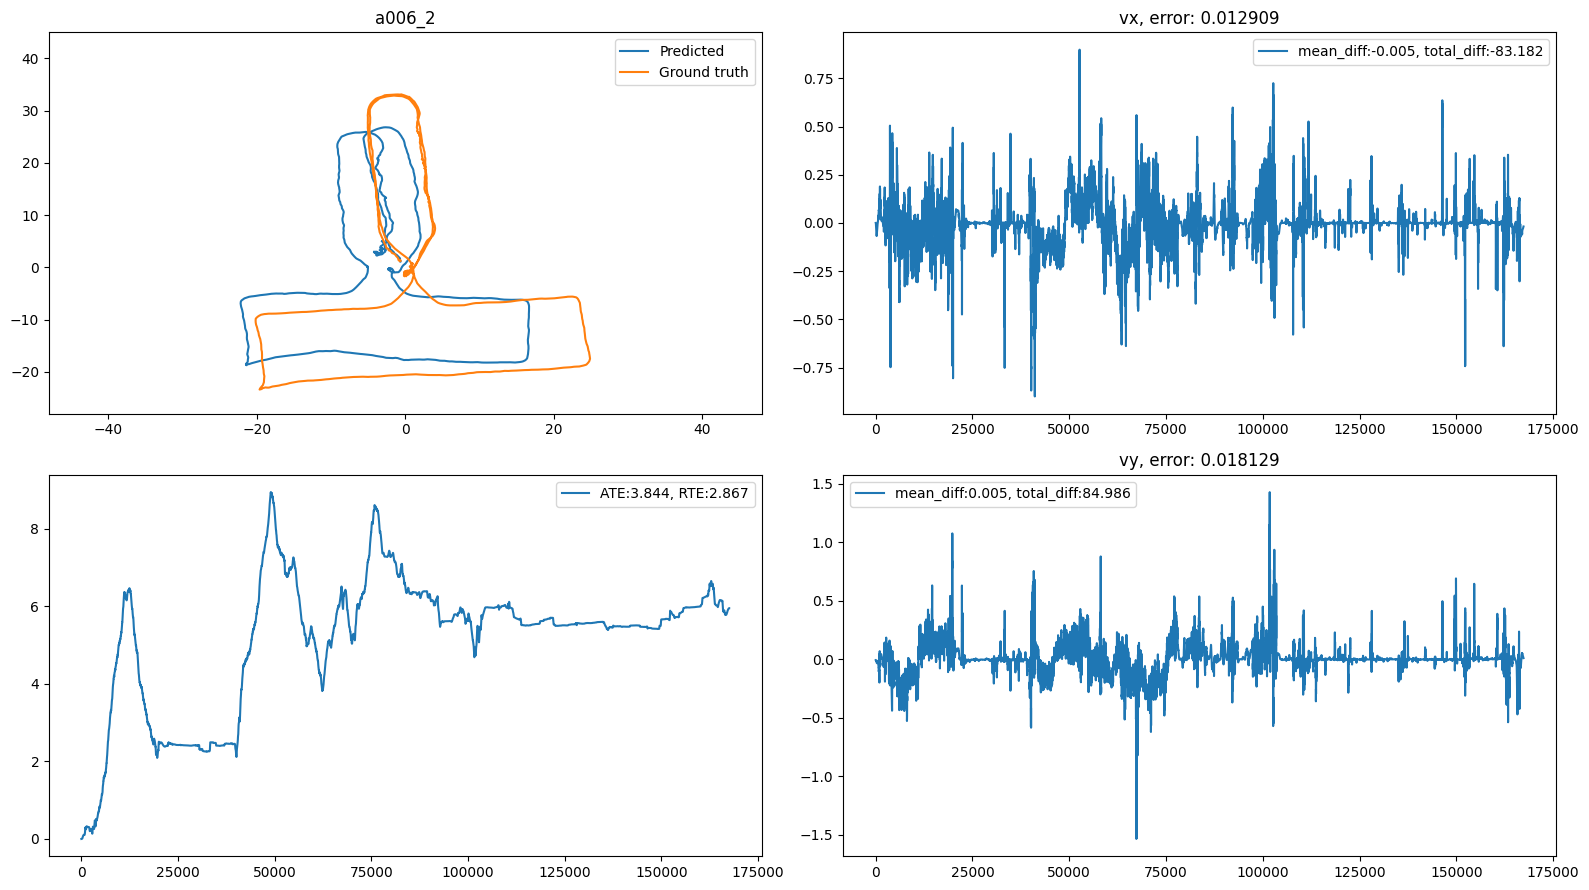

a019_3: device: samsung1, ori_error (game_rv): 1.323
Sequence a019_3, loss [0.072478 0.040962] / 0.05671986564993858, ate 5.953241, rte 5.378958
length of predictions:  8831
length of predictions:  8831


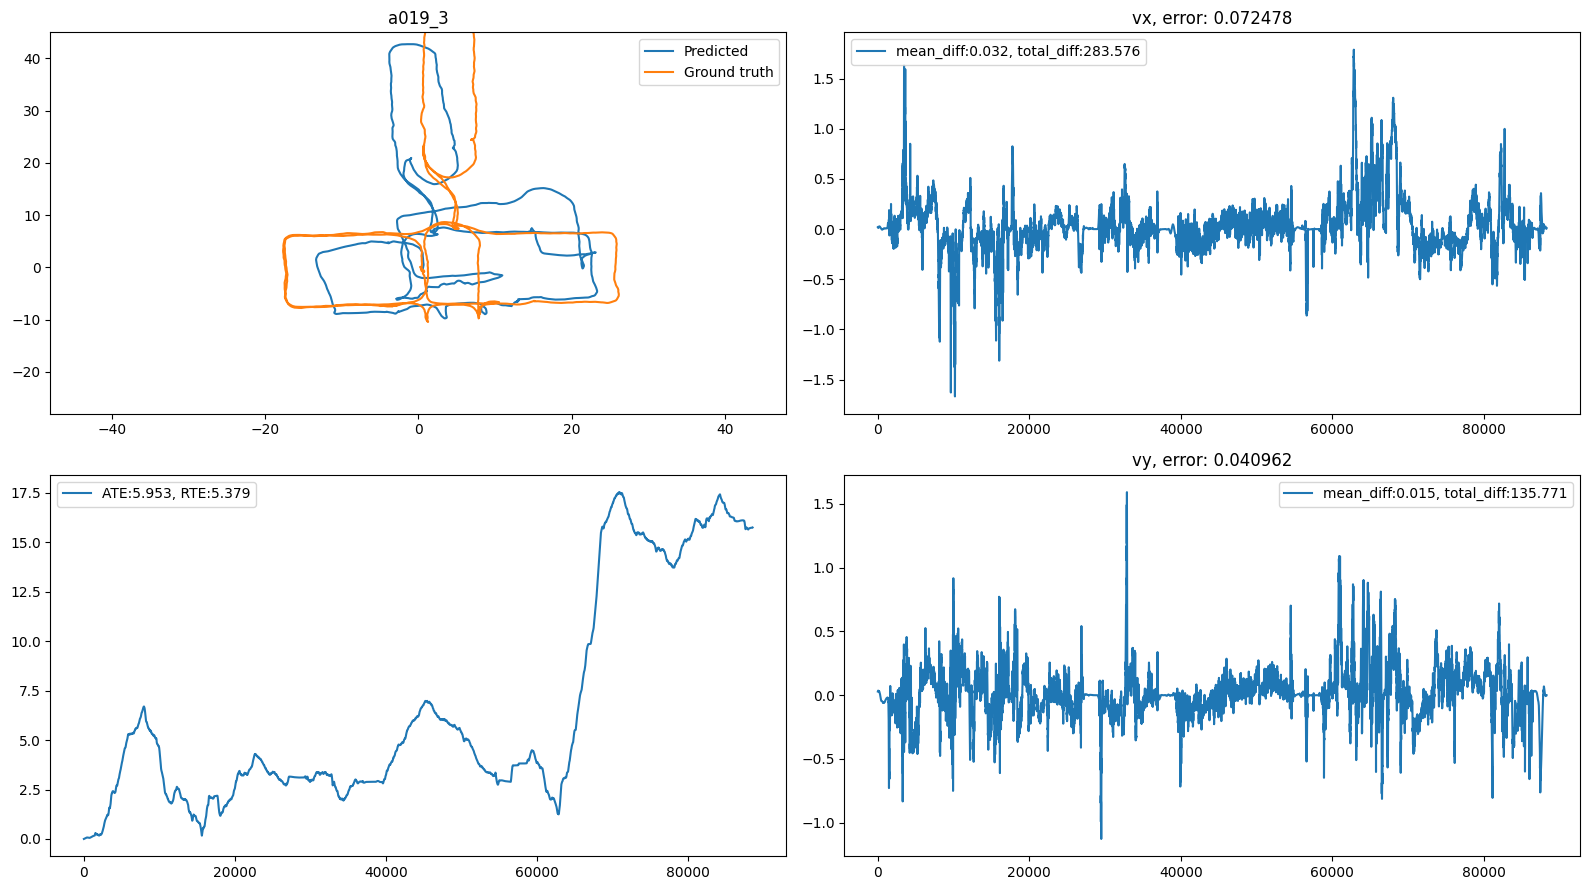

a024_1: device: samsung1, ori_error (game_rv): 10.395
Sequence a024_1, loss [0.060038 0.051800] / 0.05591944605112076, ate 2.439851, rte 2.222438
length of predictions:  9146
length of predictions:  9146


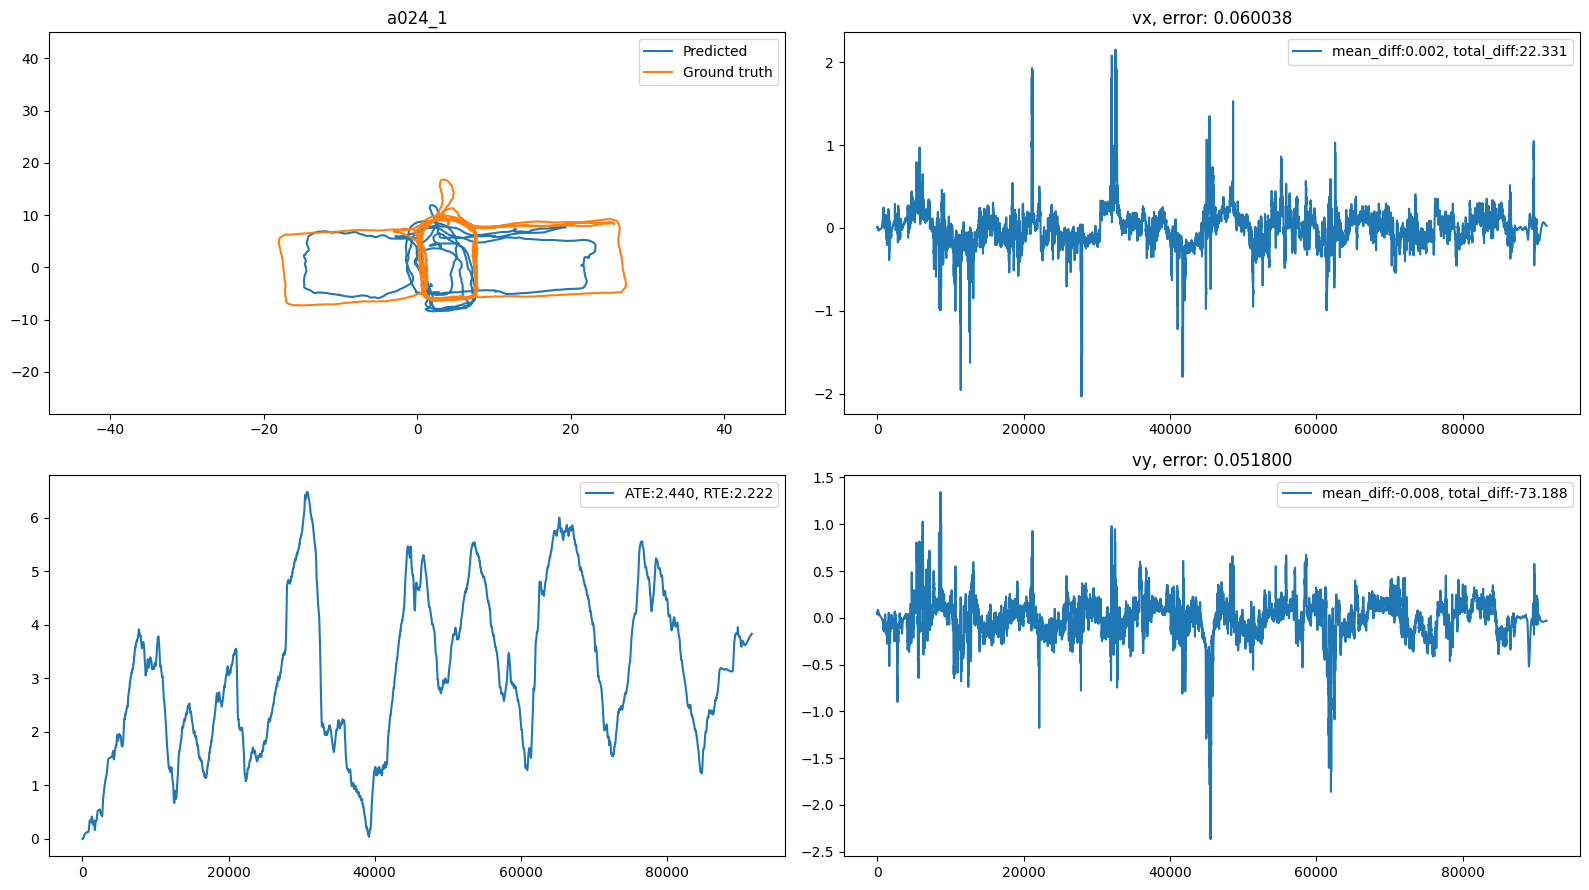

a024_3: device: samsung1, ori_error (game_rv): 3.795
Sequence a024_3, loss [0.034221 0.022183] / 0.02820206619799137, ate 3.239928, rte 2.454434
length of predictions:  10363
length of predictions:  10363


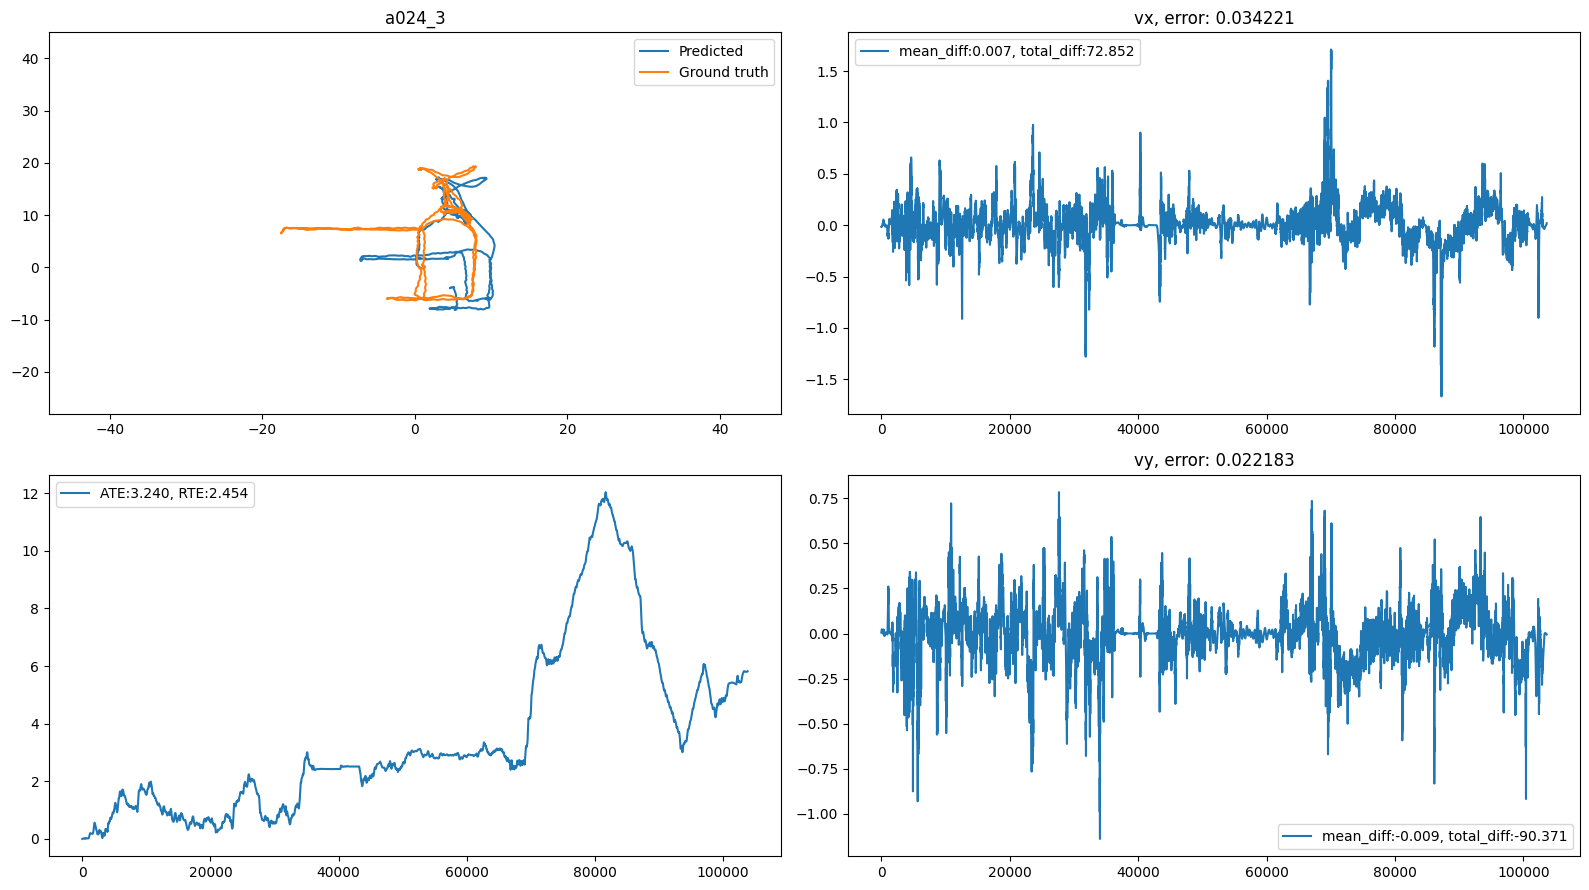

a029_1: device: samsung1, ori_error (game_rv): 18.731
Sequence a029_1, loss [0.108412 0.049141] / 0.07877613604068756, ate 4.167449, rte 6.871495
length of predictions:  8397
length of predictions:  8397


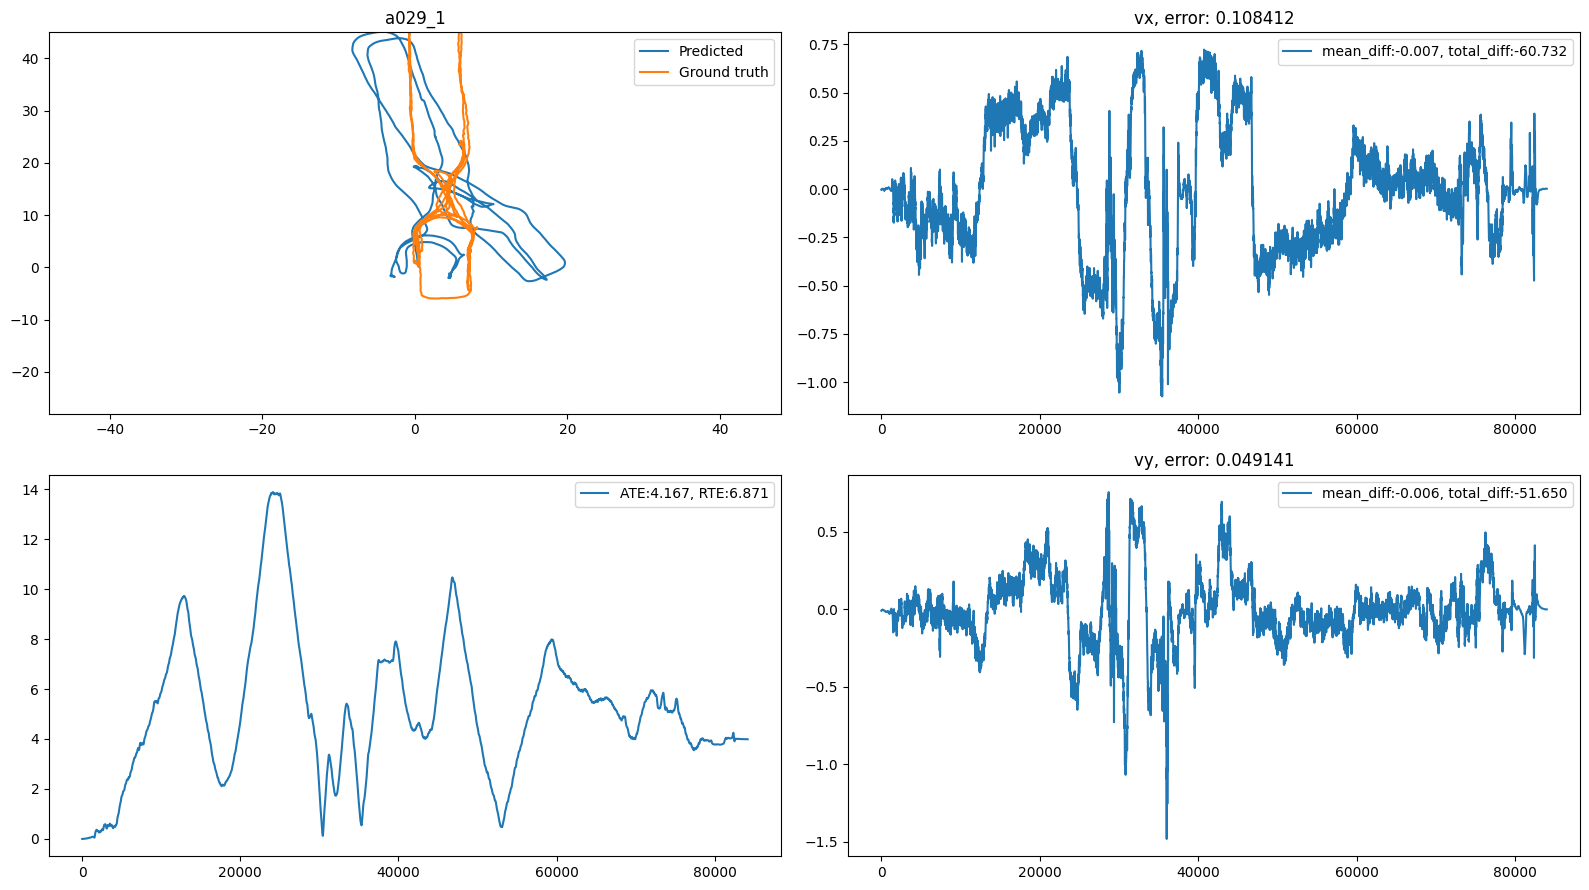

a029_2: device: samsung1, ori_error (game_rv): 10.180
Sequence a029_2, loss [0.012163 0.009754] / 0.010958529077470303, ate 2.799366, rte 1.892929
length of predictions:  10434
length of predictions:  10434


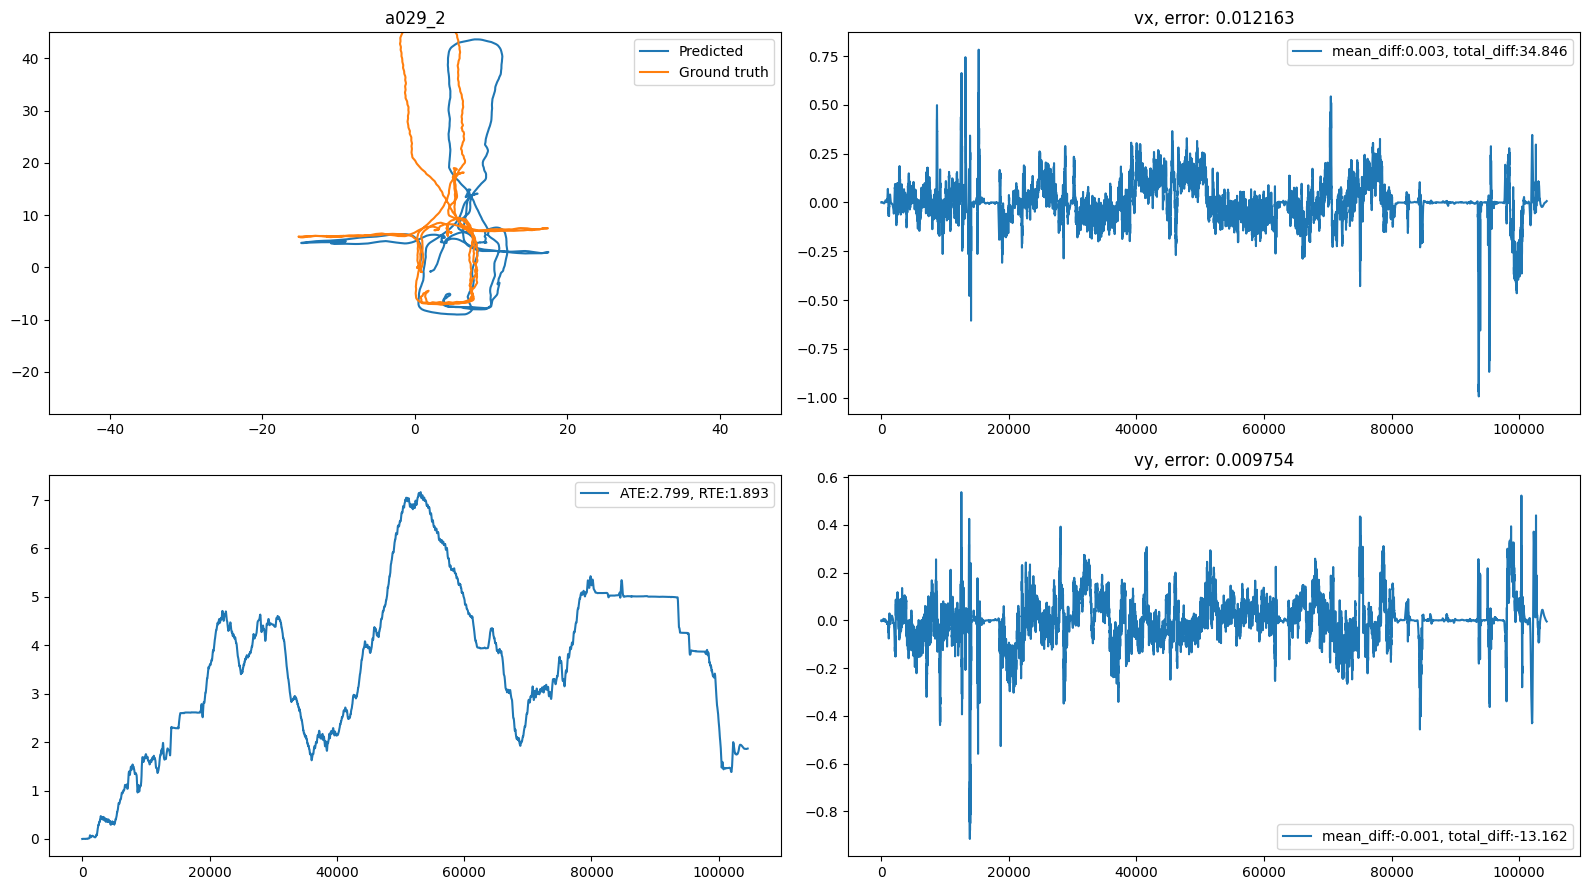

a032_1: device: asus4, ori_error (game_rv): 1.794
Sequence a032_1, loss [0.027490 0.026857] / 0.027173180133104324, ate 3.613133, rte 4.926451
length of predictions:  8540
length of predictions:  8540


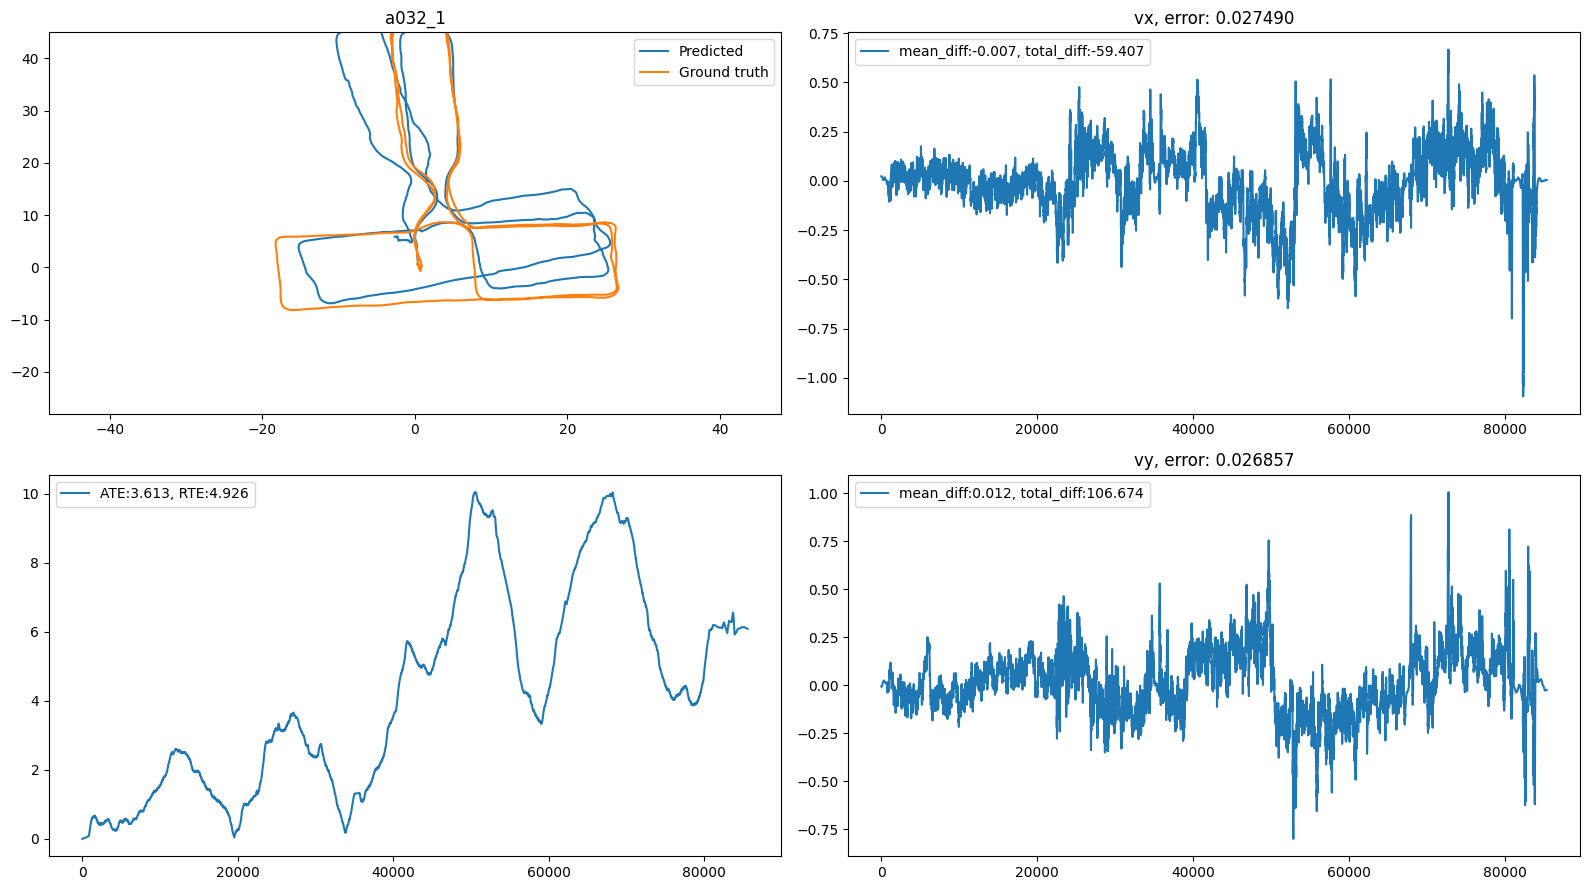

a032_3: device: asus4, ori_error (game_rv): 3.553
Sequence a032_3, loss [0.093912 0.105058] / 0.09948519617319107, ate 14.603213, rte 6.787858
length of predictions:  13833
length of predictions:  13833


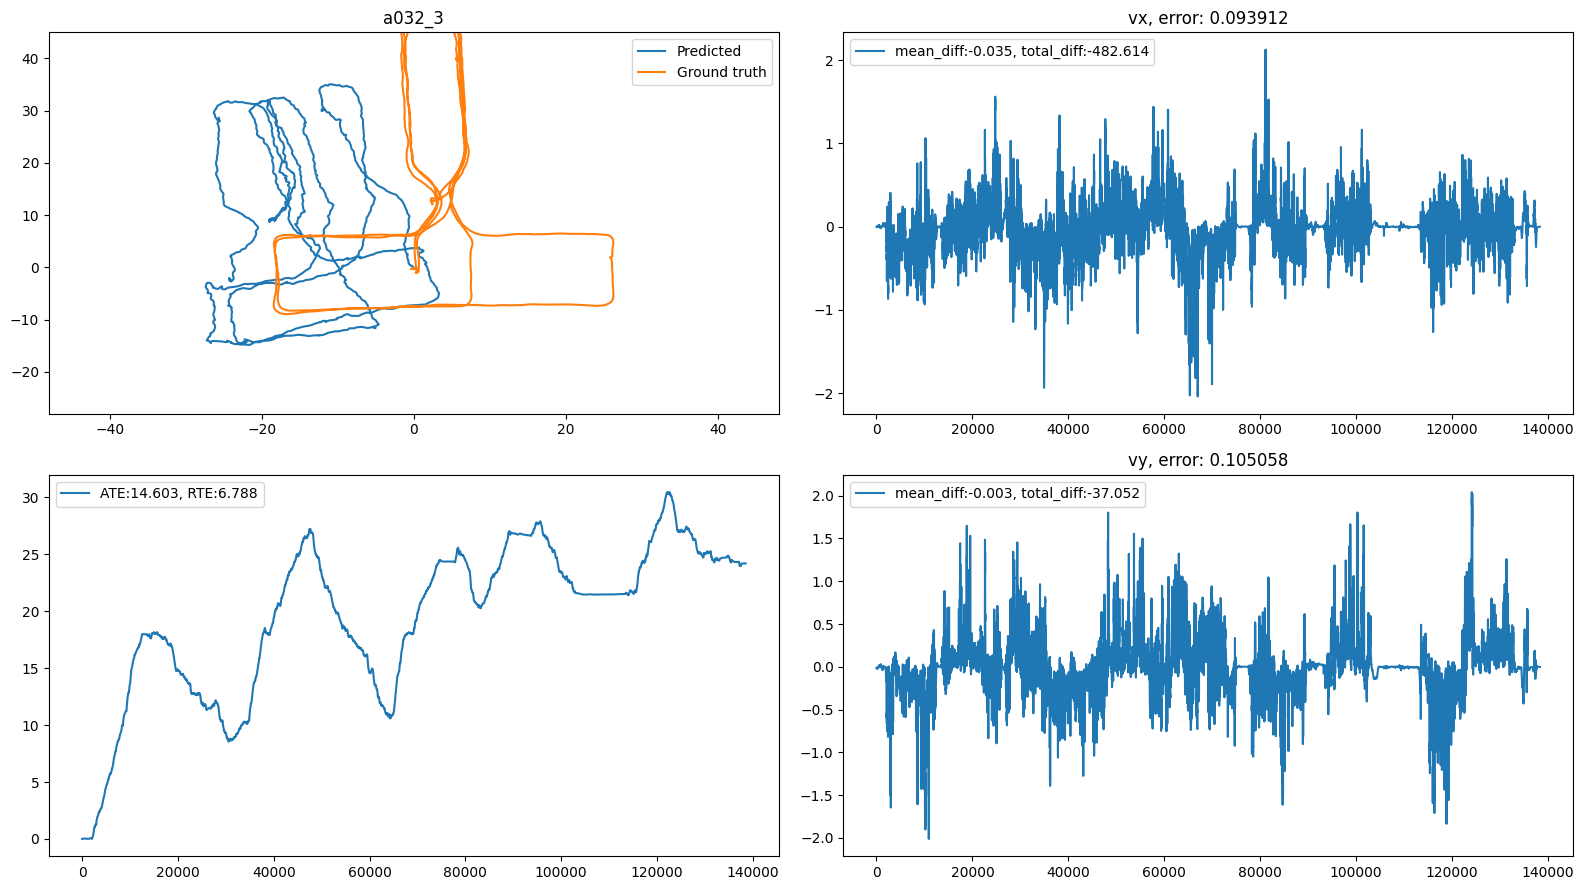

a042_2: device: asus4, ori_error (game_rv): 12.481
Sequence a042_2, loss [0.046112 0.032228] / 0.0391698032617569, ate 4.668771, rte 5.054253
length of predictions:  14313
length of predictions:  14313


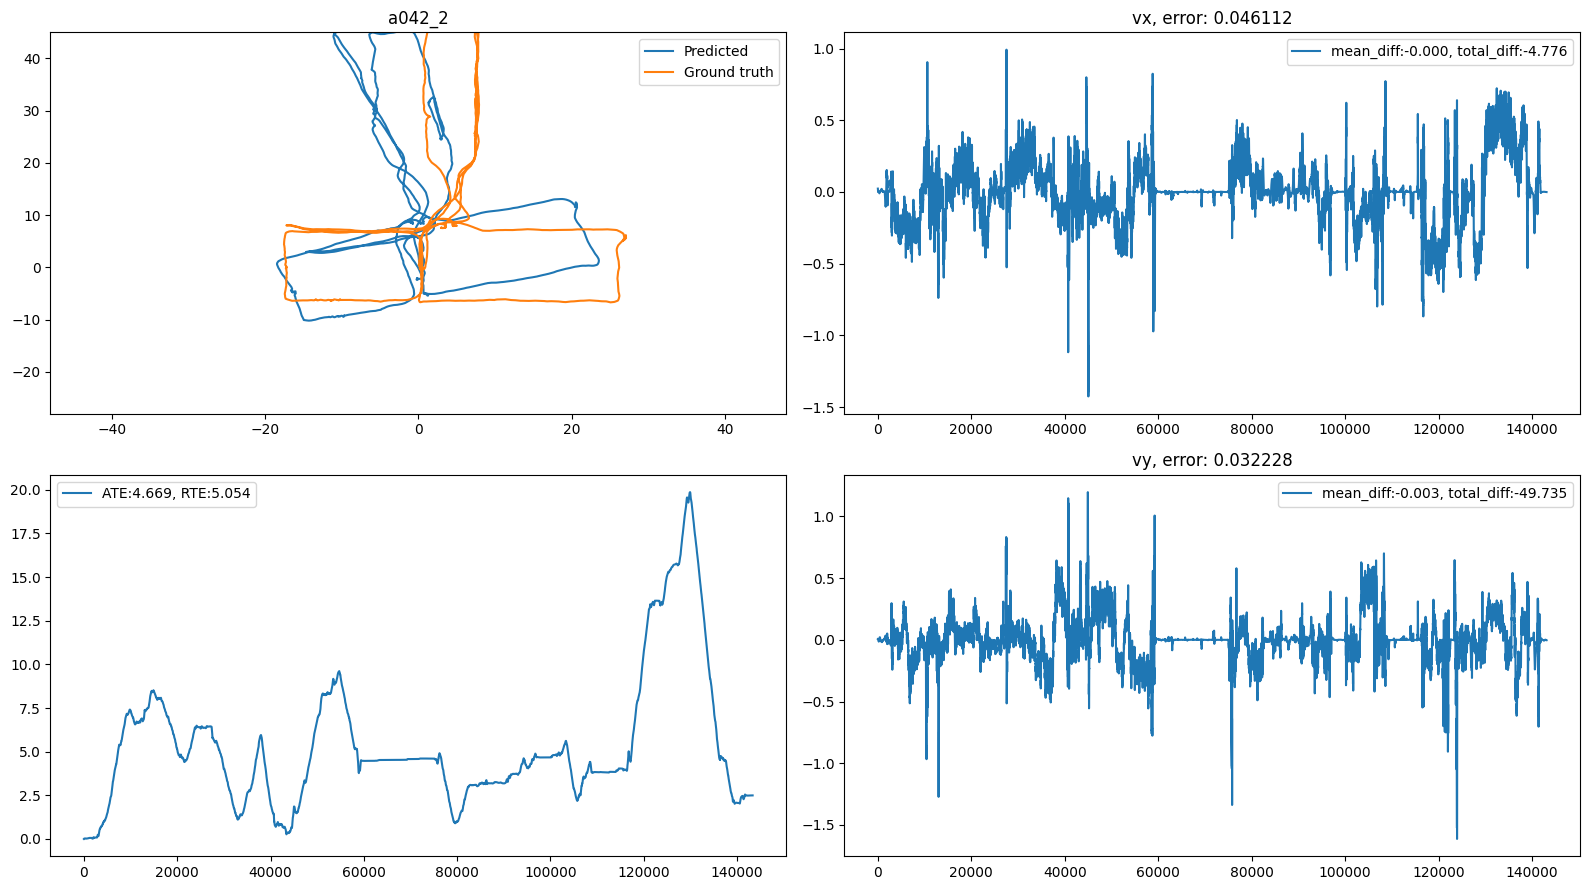

a049_1: device: asus7, ori_error (game_rv): 34.273
Sequence a049_1, loss [0.054717 0.065133] / 0.05992502719163895, ate 4.309207, rte 6.344181
length of predictions:  6917
length of predictions:  6917


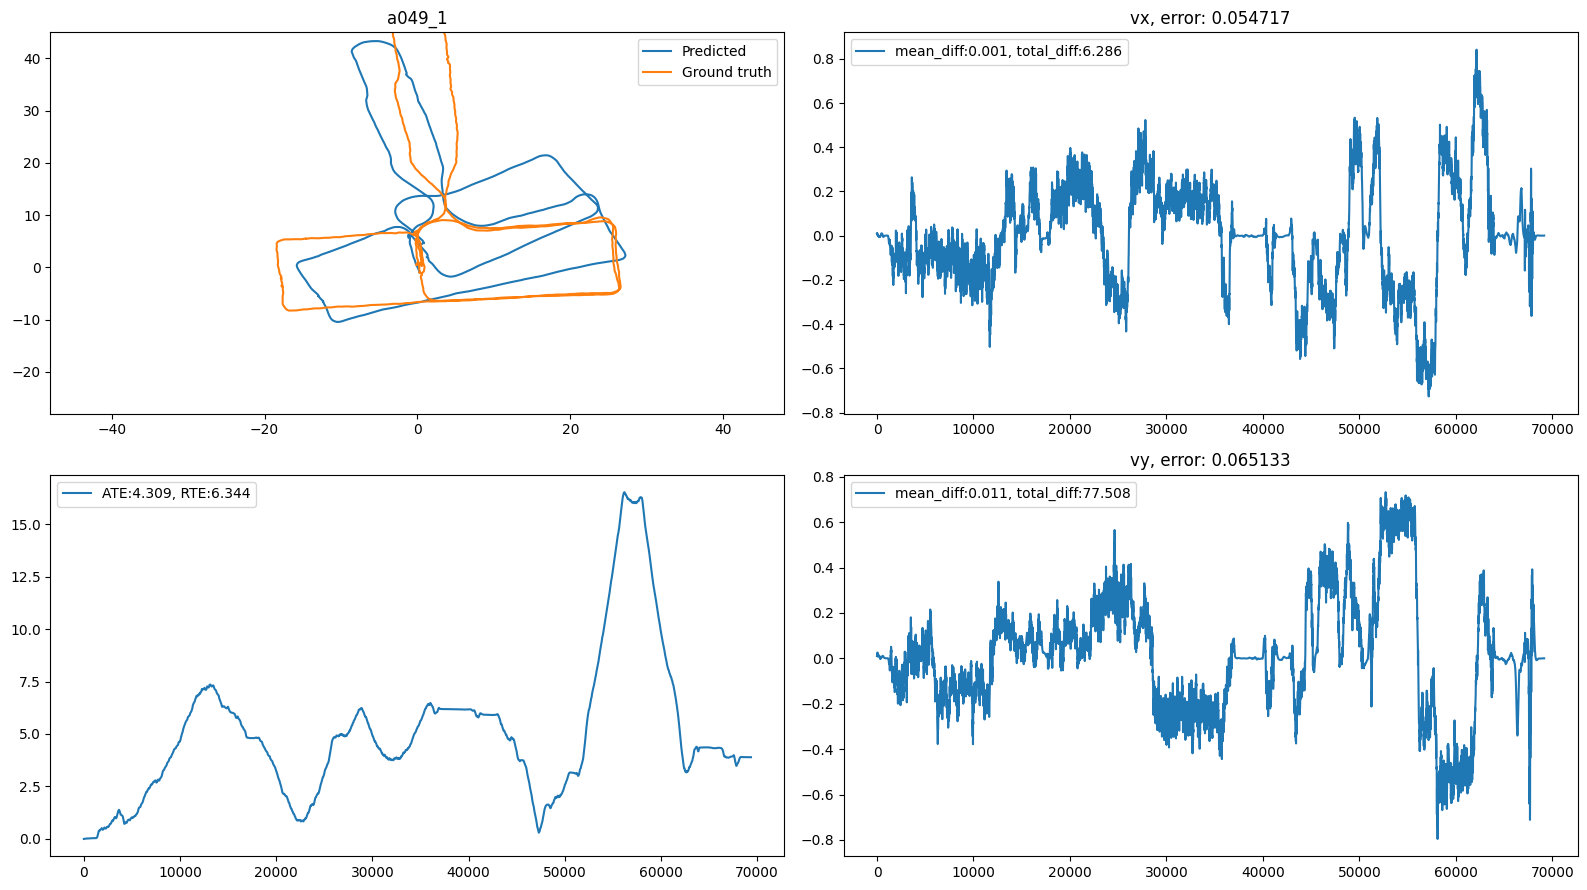

a049_2: device: asus7, ori_error (game_rv): 5.120
Sequence a049_2, loss [0.016818 0.013340] / 0.015079103410243988, ate 2.240766, rte 2.364747
length of predictions:  13218
length of predictions:  13218


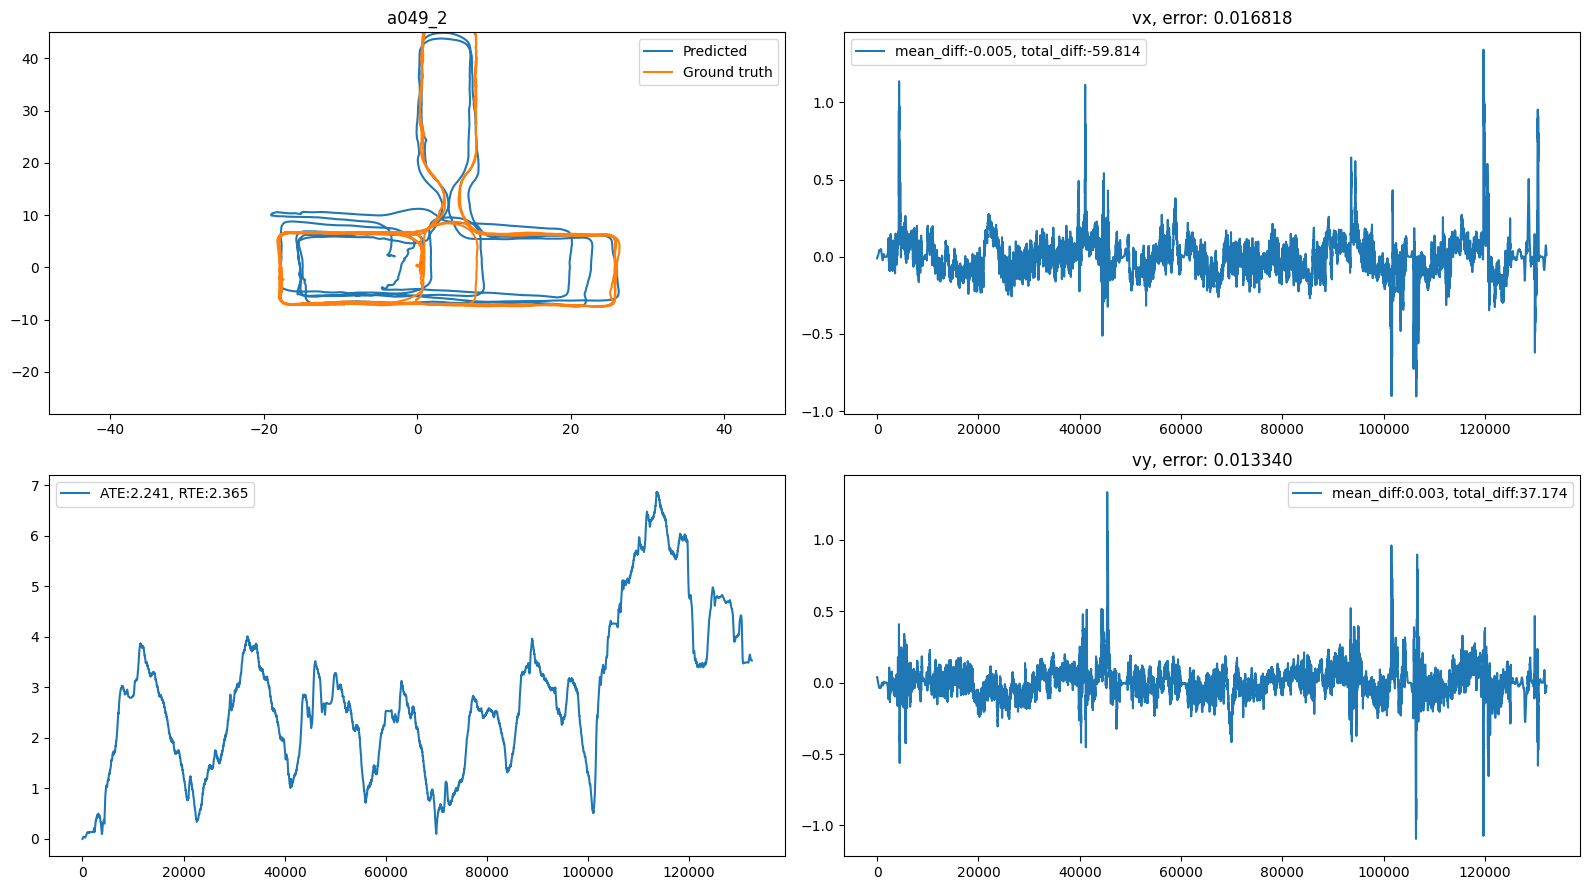

a049_3: device: asus7, ori_error (game_rv): 6.177
Sequence a049_3, loss [0.012346 0.013938] / 0.013141939416527748, ate 2.136302, rte 2.359643
length of predictions:  12916
length of predictions:  12916


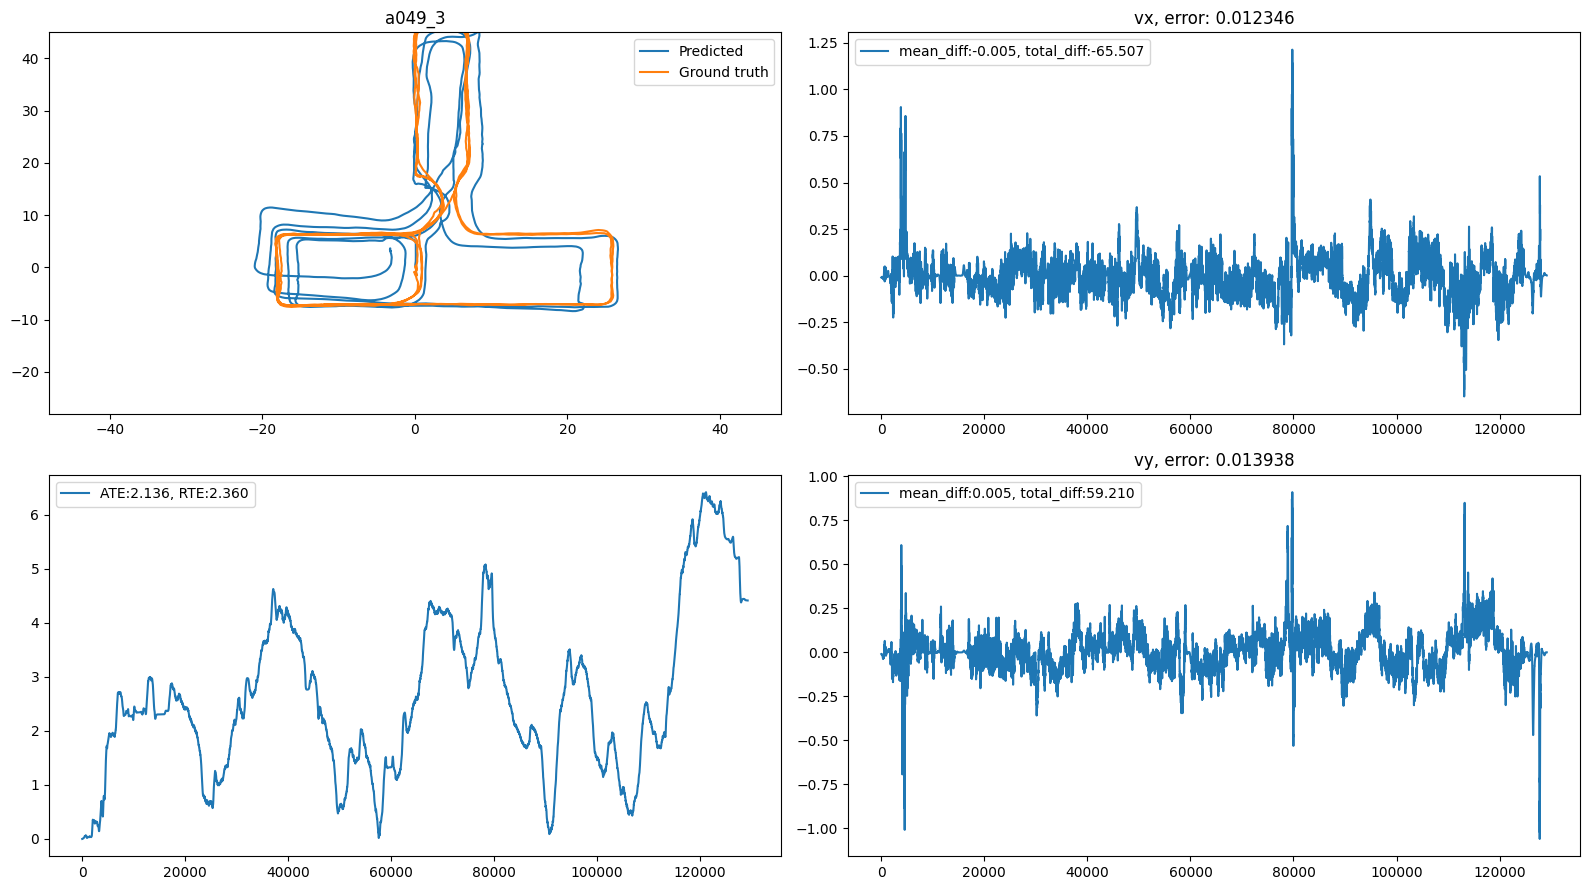

a050_1: device: samsung1, ori_error (game_rv): 7.429
Sequence a050_1, loss [0.051034 0.048577] / 0.049805451184511185, ate 10.288030, rte 6.277725
length of predictions:  7117
length of predictions:  7117


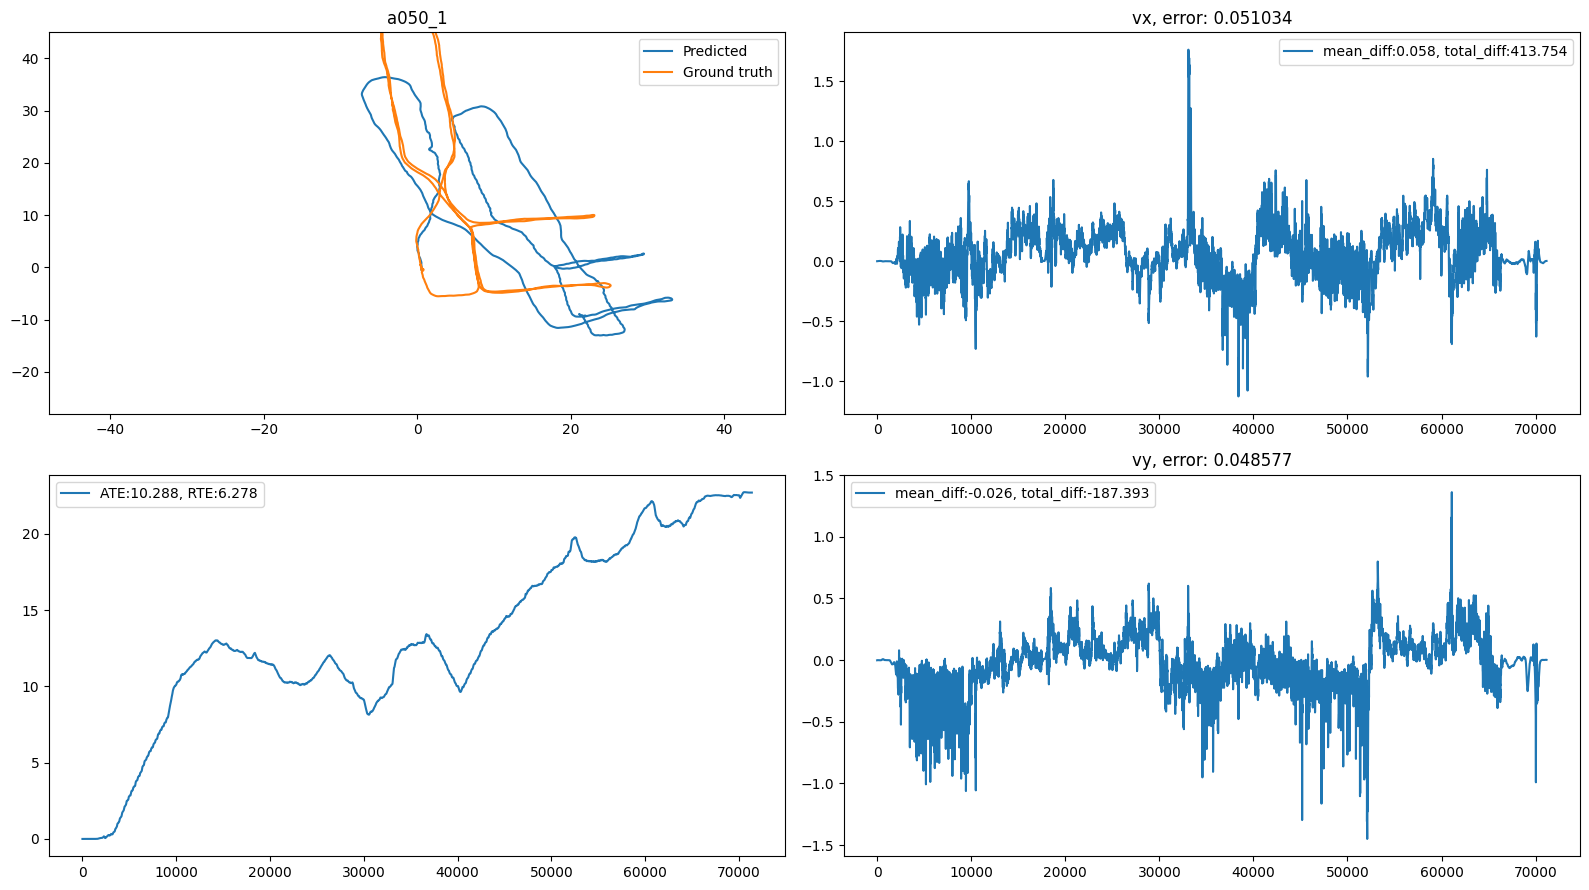

a050_3: device: samsung1, ori_error (game_rv): 11.619
Sequence a050_3, loss [0.061191 0.104476] / 0.08283324539661407, ate 13.849707, rte 7.361011
length of predictions:  13266
length of predictions:  13266


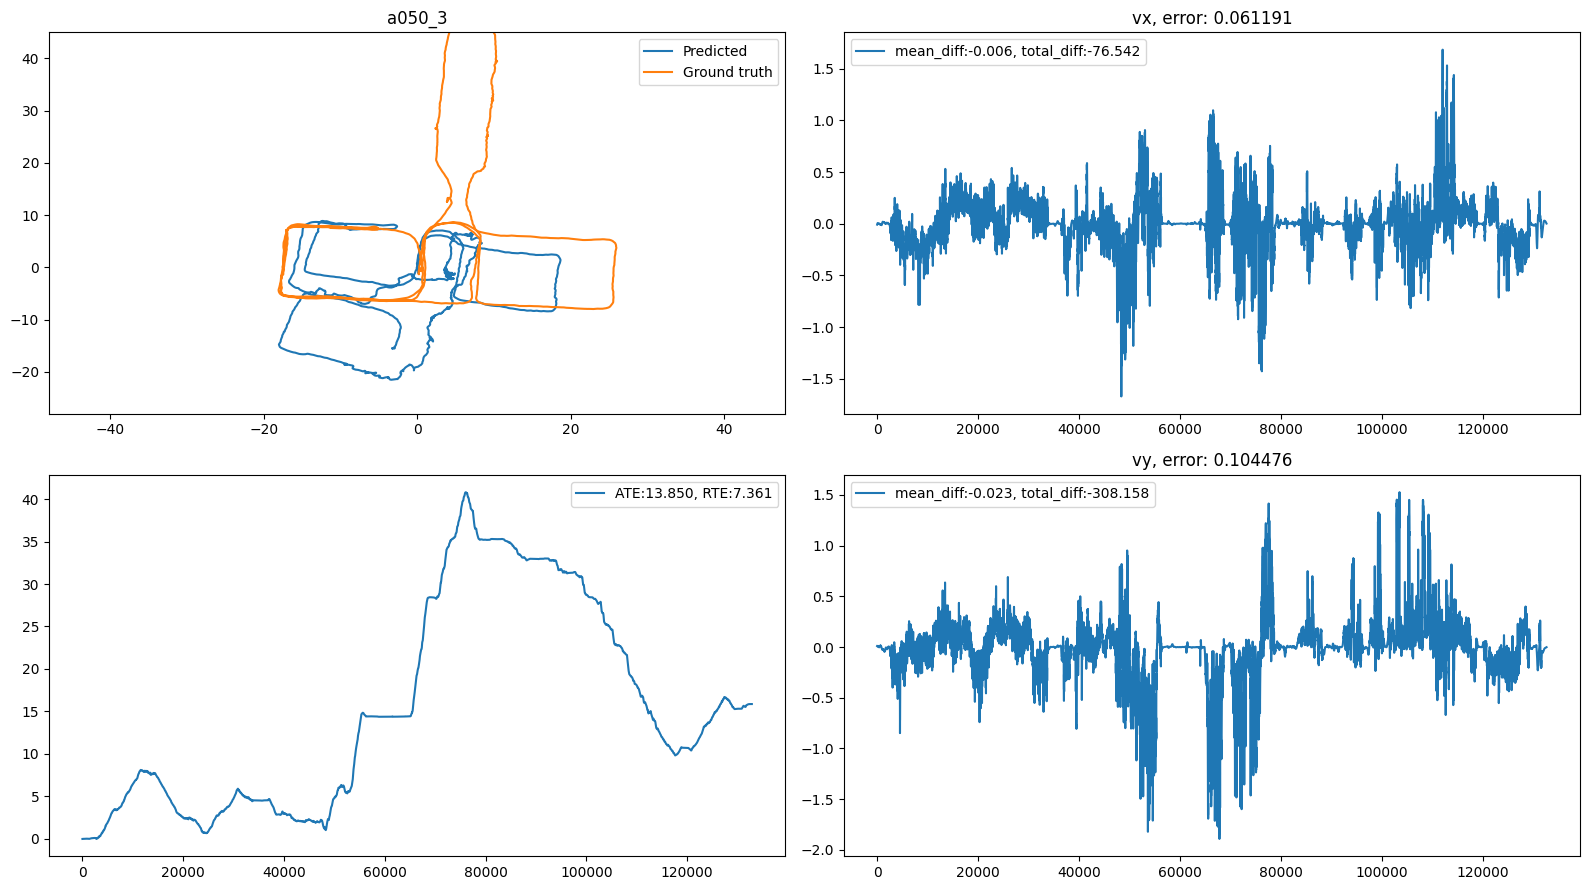

a051_1: device: asus4, ori_error (game_rv): 35.594
Sequence a051_1, loss [0.033351 0.037902] / 0.03562608361244202, ate 6.490041, rte 4.917007
length of predictions:  18068
length of predictions:  18068


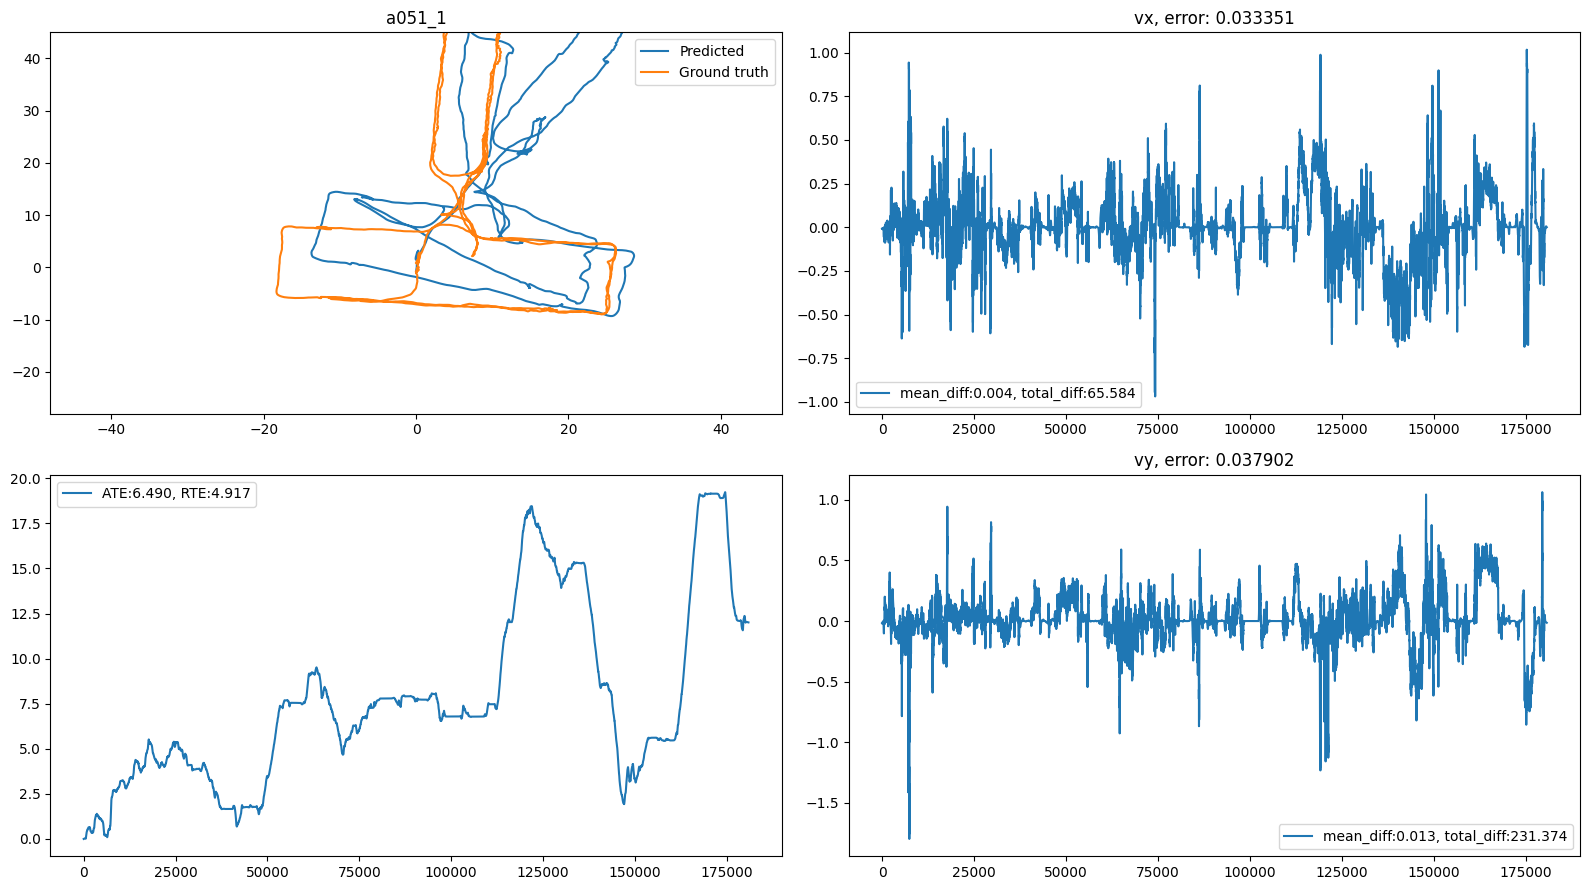

a051_2: device: asus4, ori_error (game_rv): 13.092
Sequence a051_2, loss [0.008919 0.009336] / 0.009127862751483917, ate 3.477512, rte 1.366791
length of predictions:  14416
length of predictions:  14416


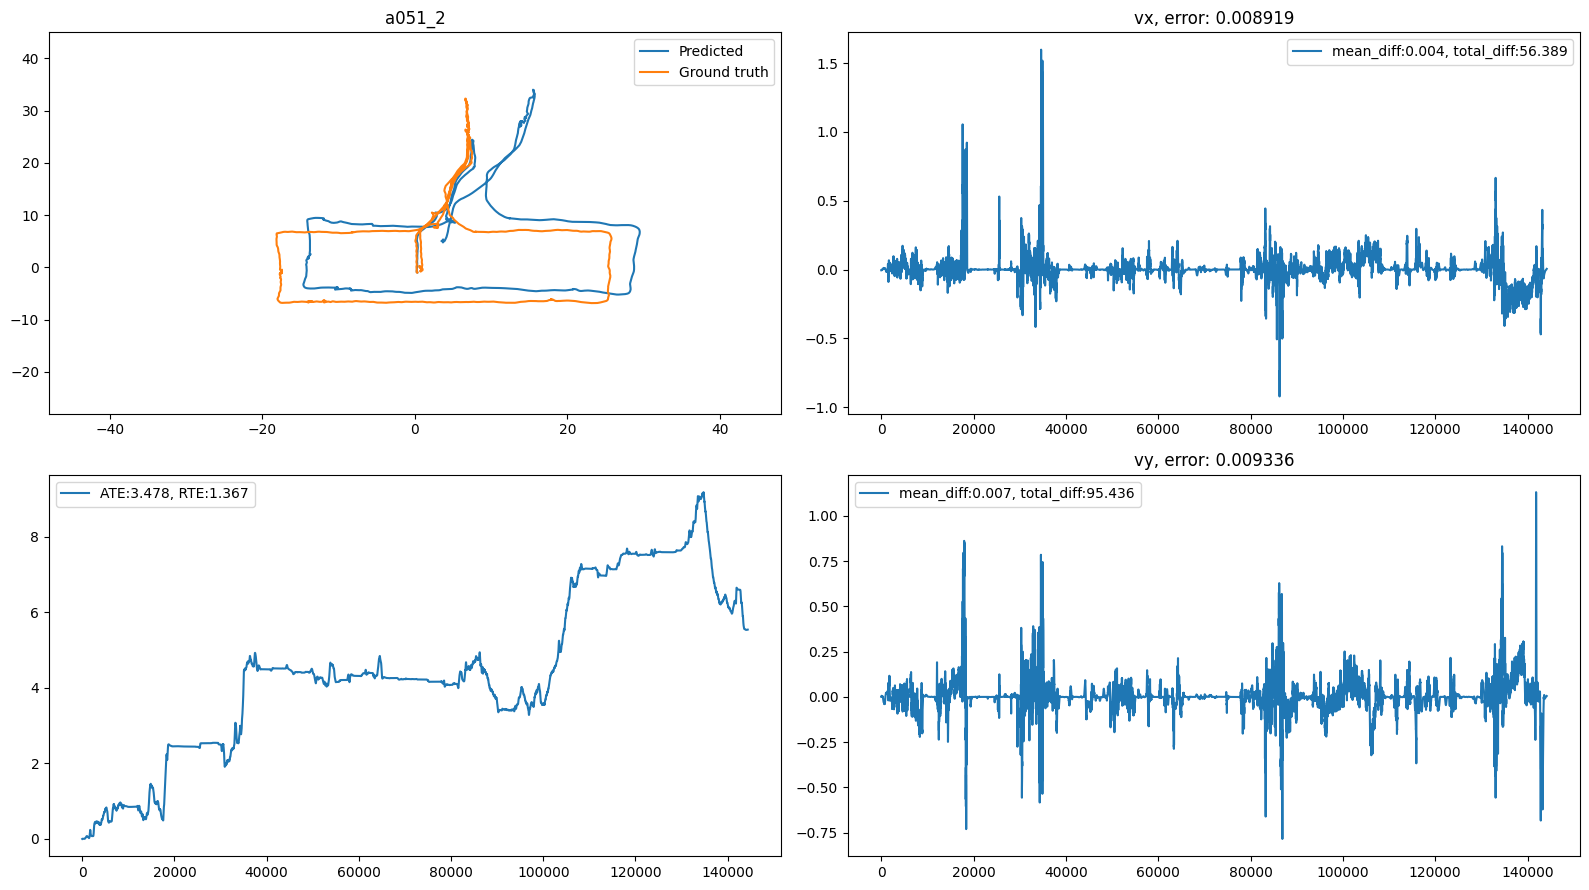

a051_3: device: asus4, ori_error (game_rv): 0.750
Sequence a051_3, loss [0.017701 0.011692] / 0.014696365222334862, ate 1.356211, rte 1.526227
length of predictions:  7521
length of predictions:  7521


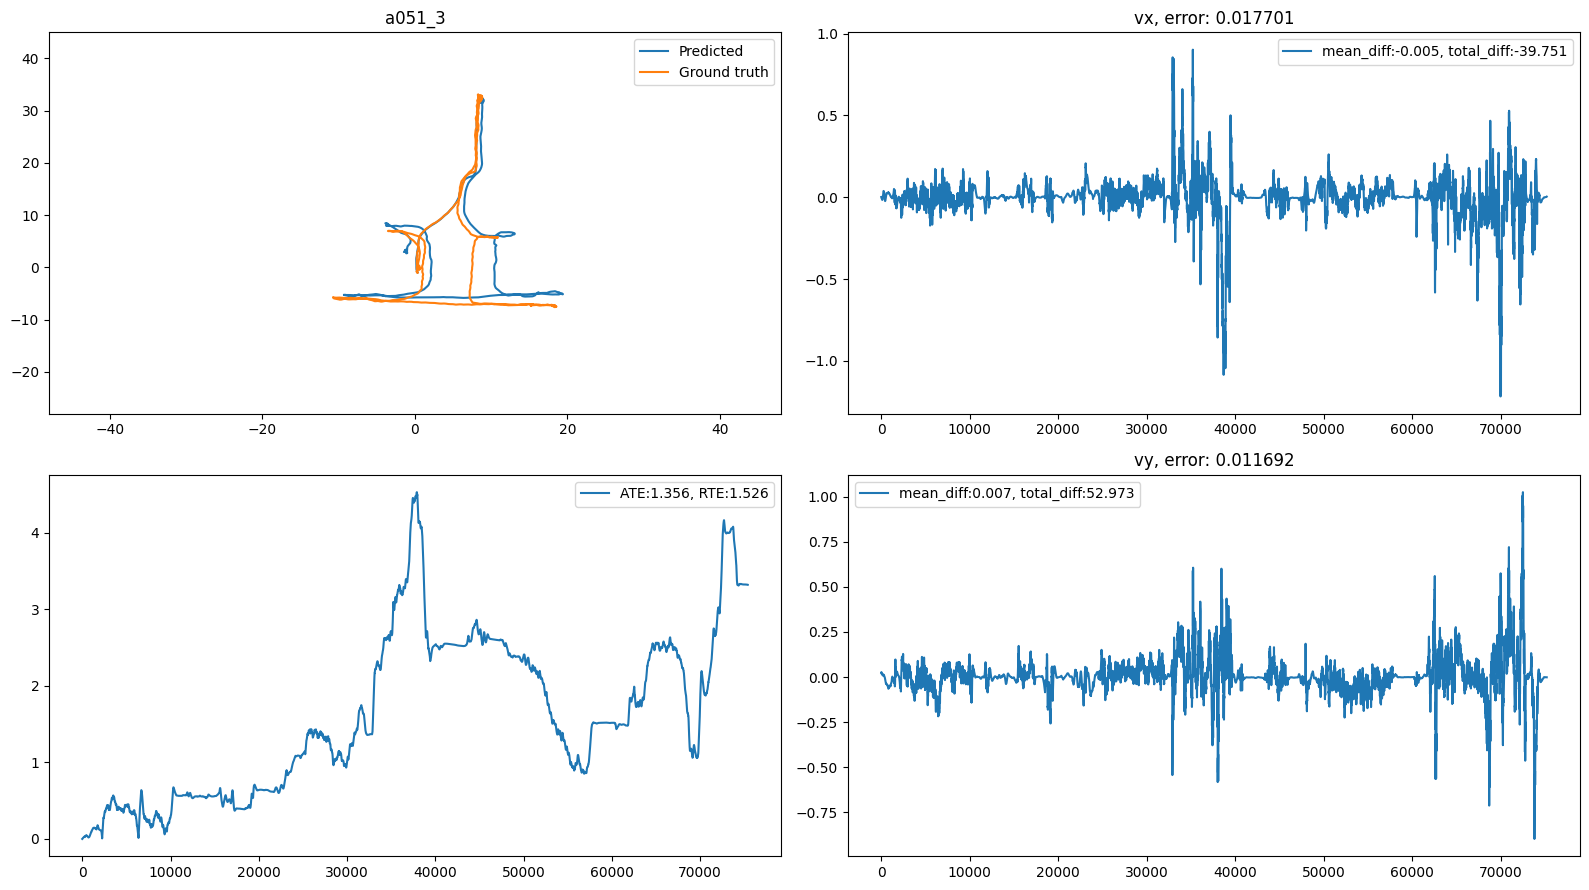

a052_2: device: samsung1, ori_error (game_rv): 8.257
Sequence a052_2, loss [0.077617 0.101398] / 0.08950735628604889, ate 4.977903, rte 7.693131
length of predictions:  7260
length of predictions:  7260


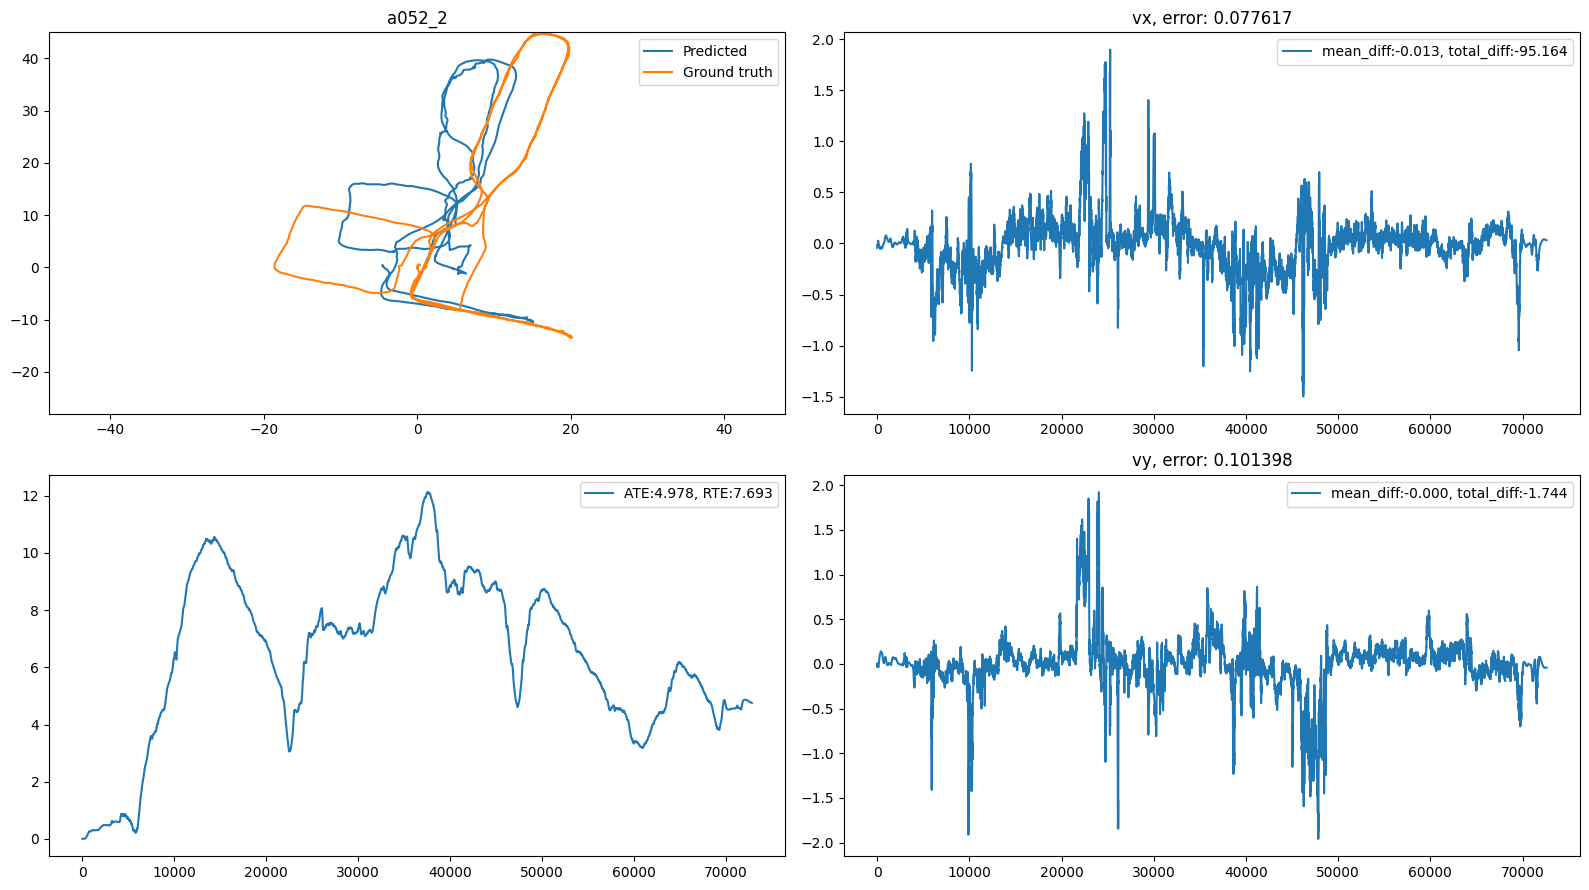

a053_1: device: asus4, ori_error (game_rv): 20.488
Sequence a053_1, loss [0.025685 0.015791] / 0.020738262683153152, ate 2.957206, rte 3.828379
length of predictions:  9149
length of predictions:  9149


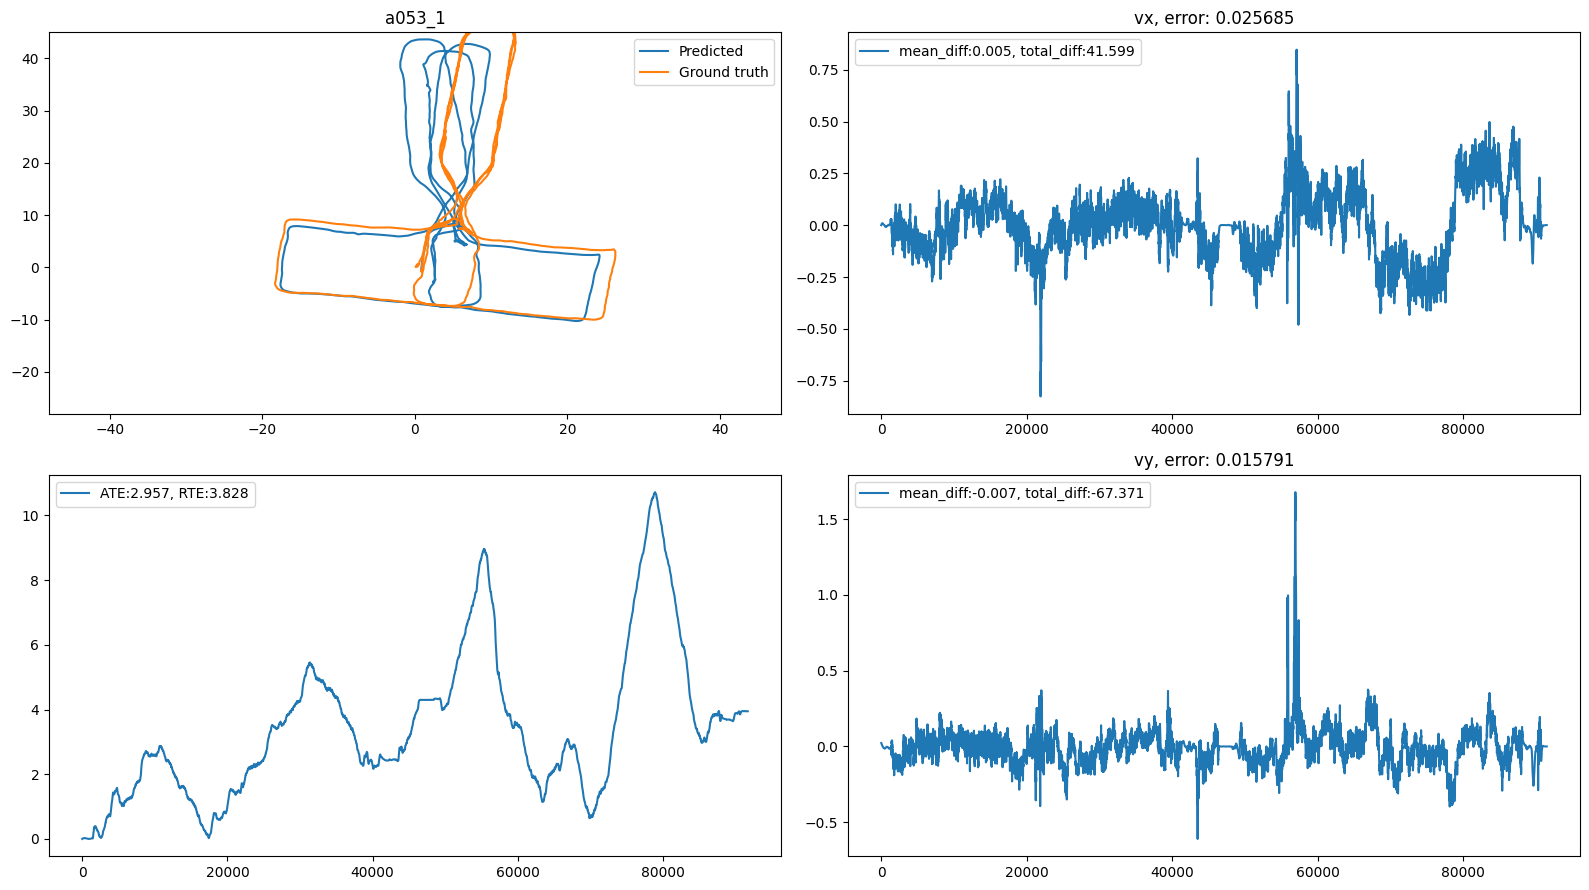

a053_2: device: asus4, ori_error (game_rv): 2.682
Sequence a053_2, loss [0.008513 0.012668] / 0.010590450838208199, ate 4.627539, rte 2.345107
length of predictions:  12750
length of predictions:  12750


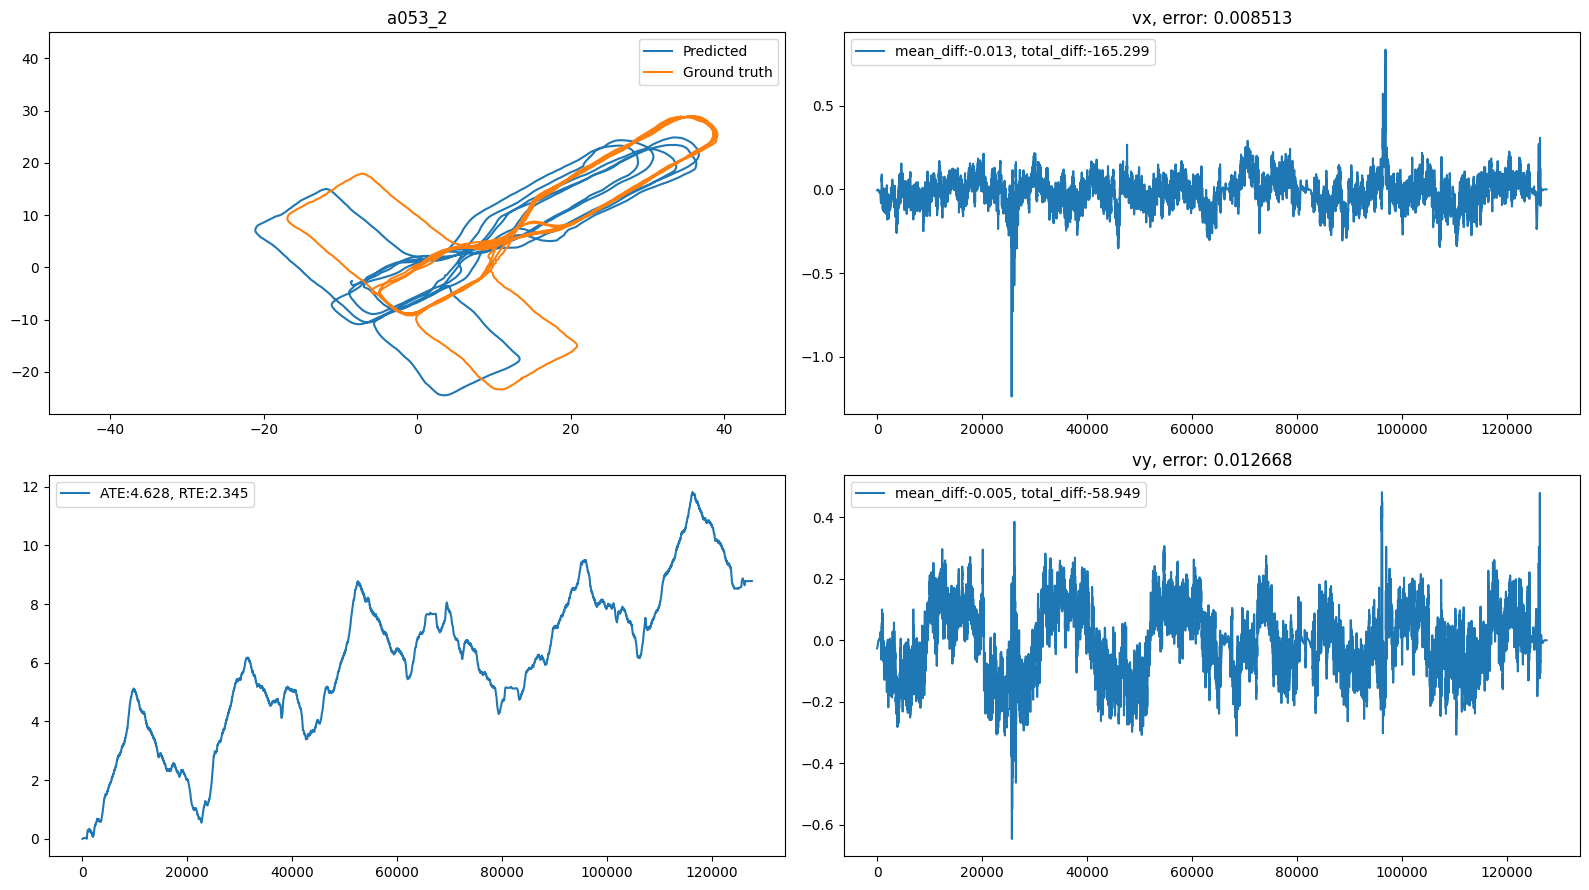

a053_3: device: asus4, ori_error (game_rv): 4.051
Sequence a053_3, loss [0.007651 0.012032] / 0.00984190870076418, ate 4.198560, rte 2.266219
length of predictions:  11772
length of predictions:  11772


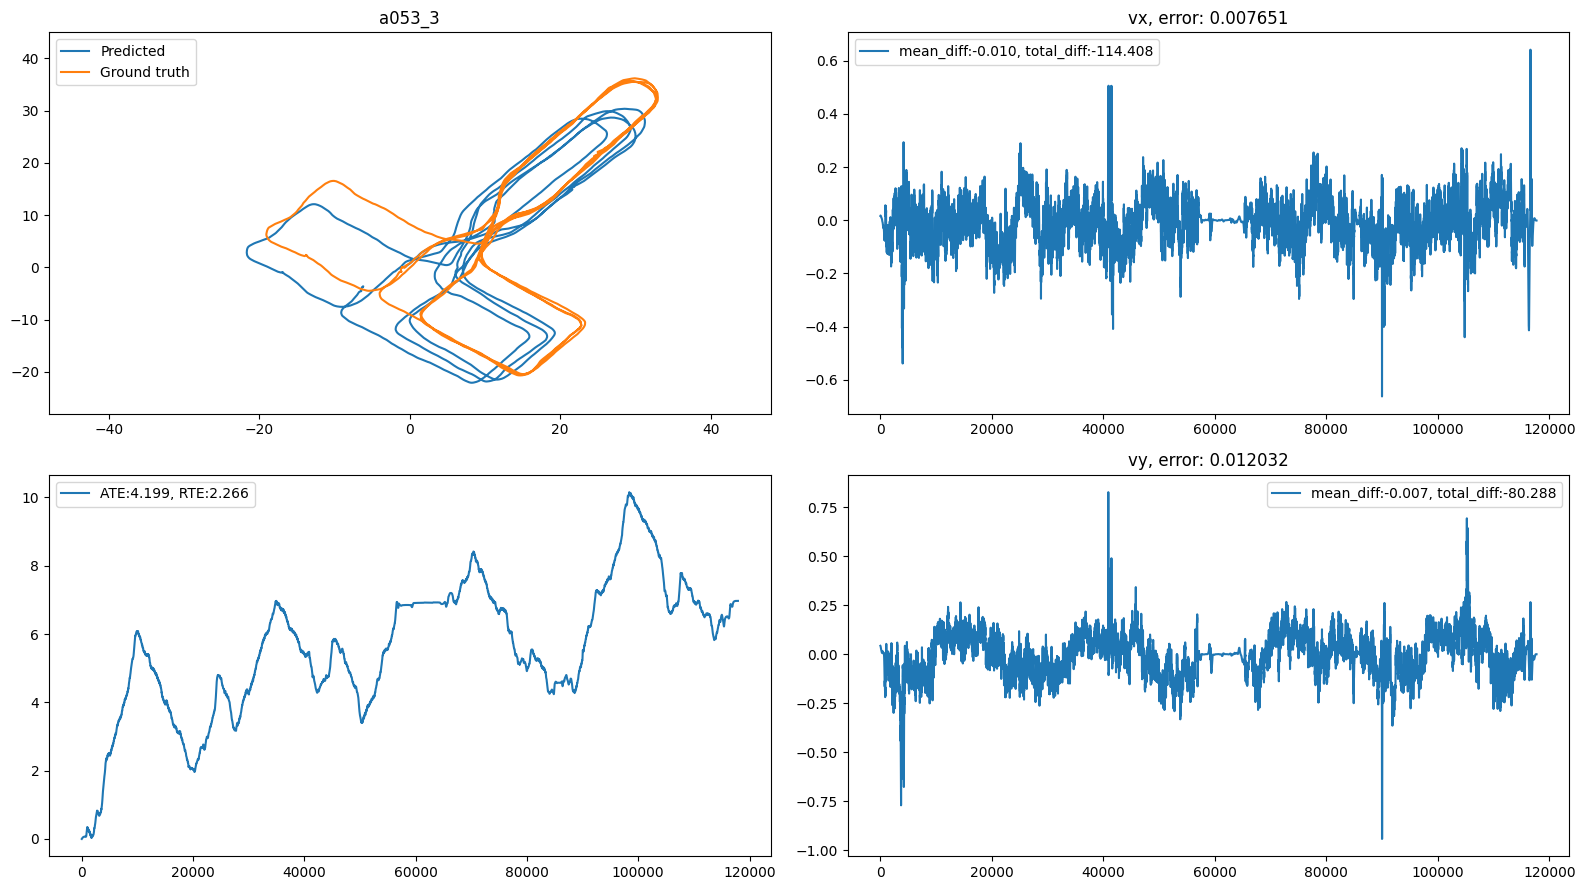

a054_1: device: asus4, ori_error (game_rv): 12.810
Sequence a054_1, loss [0.039620 0.022627] / 0.031123237684369087, ate 2.883220, rte 3.960119
length of predictions:  6821
length of predictions:  6821


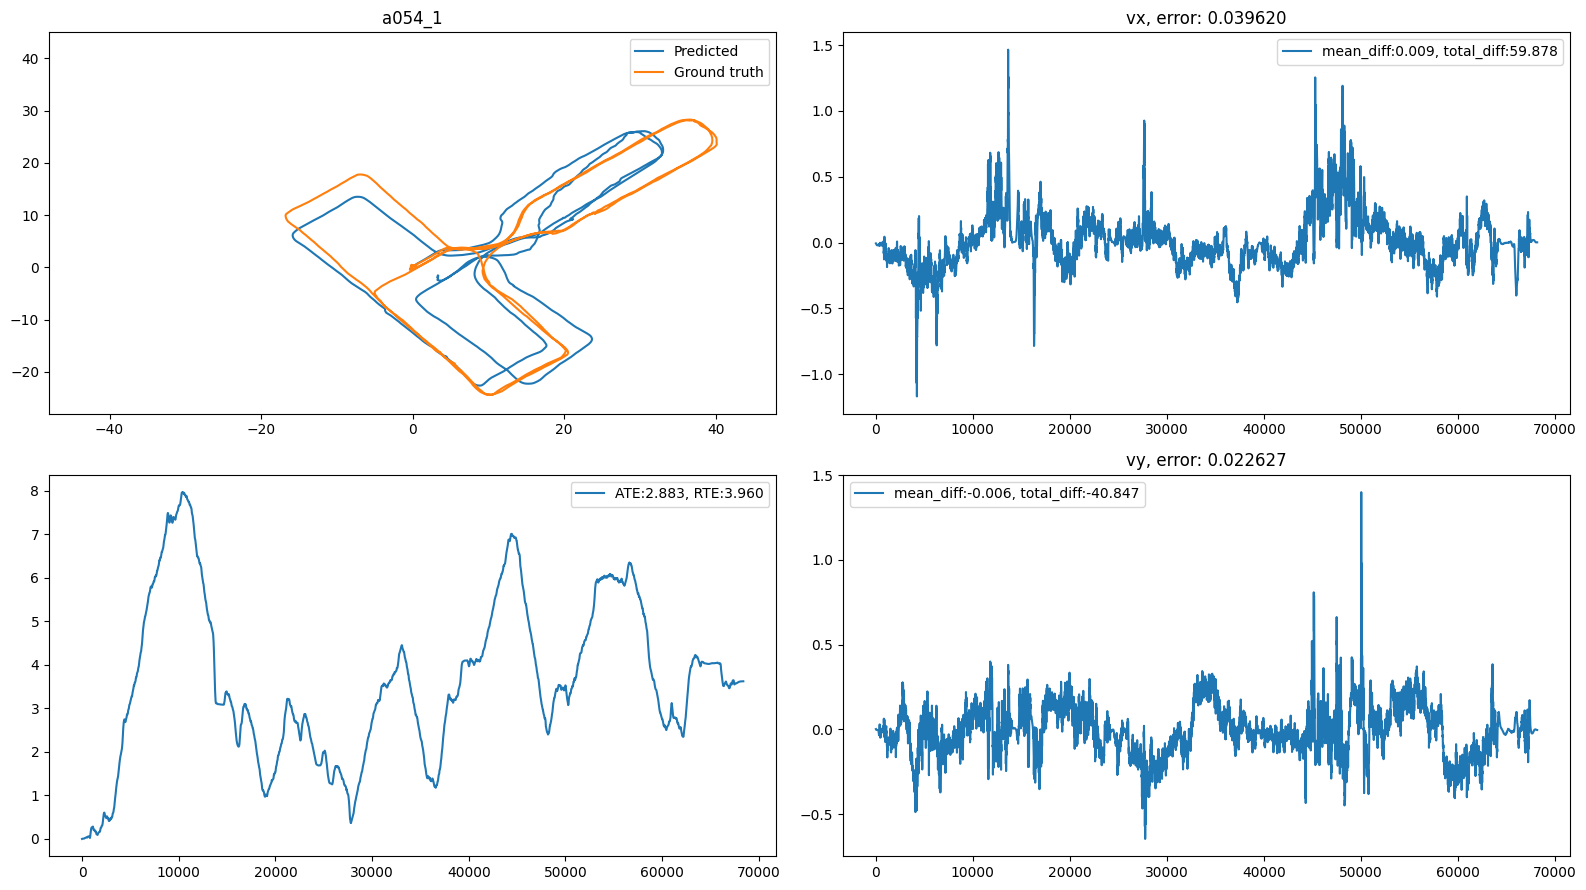

a054_2: device: asus4, ori_error (game_rv): 2.087
Sequence a054_2, loss [0.018194 0.015152] / 0.016673214733600616, ate 2.418334, rte 2.740892
length of predictions:  12133
length of predictions:  12133


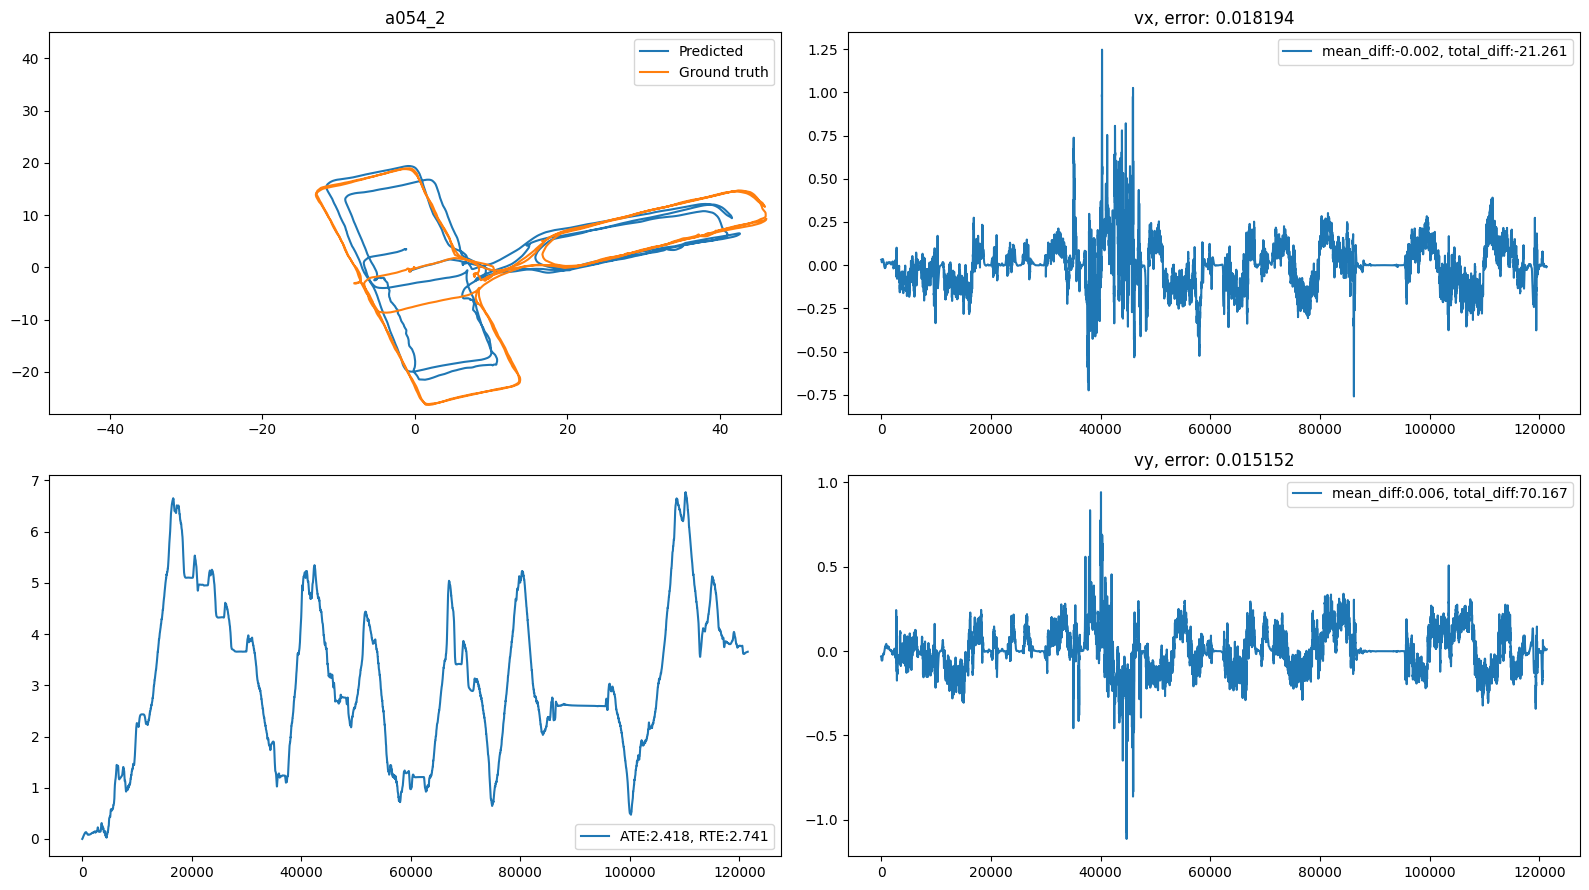

a054_3: device: asus4, ori_error (game_rv): 5.550
Sequence a054_3, loss [0.032257 0.034727] / 0.033491991460323334, ate 5.237608, rte 3.859691
length of predictions:  13374
length of predictions:  13374


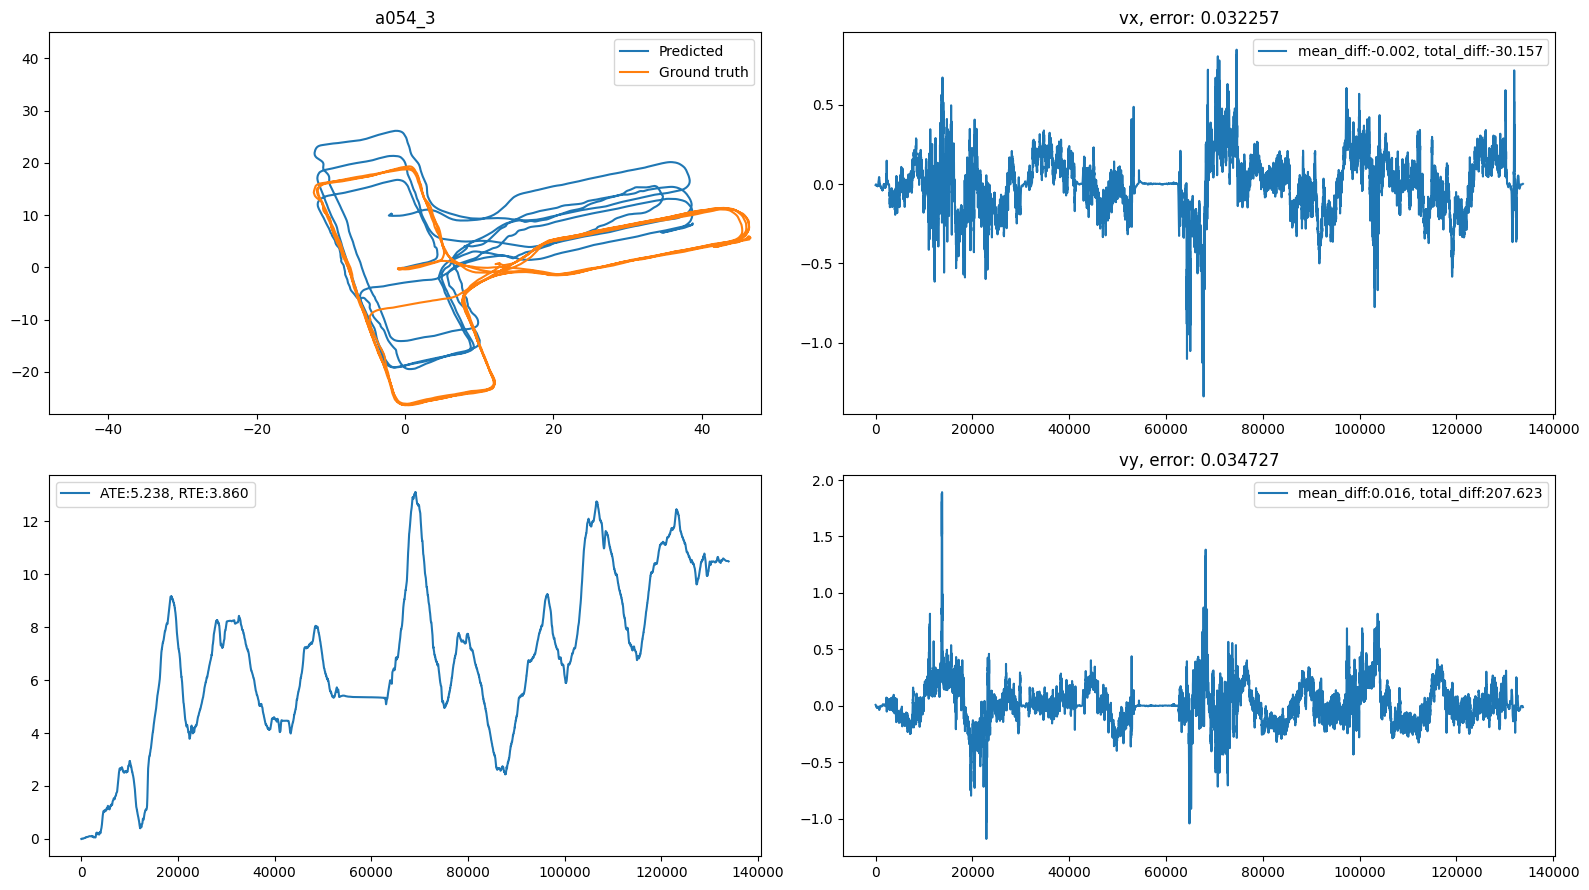

a055_2: device: asus3, ori_error (game_rv): 0.887
Sequence a055_2, loss [0.079971 0.083045] / 0.08150818943977356, ate 7.216413, rte 5.019533
length of predictions:  13414
length of predictions:  13414


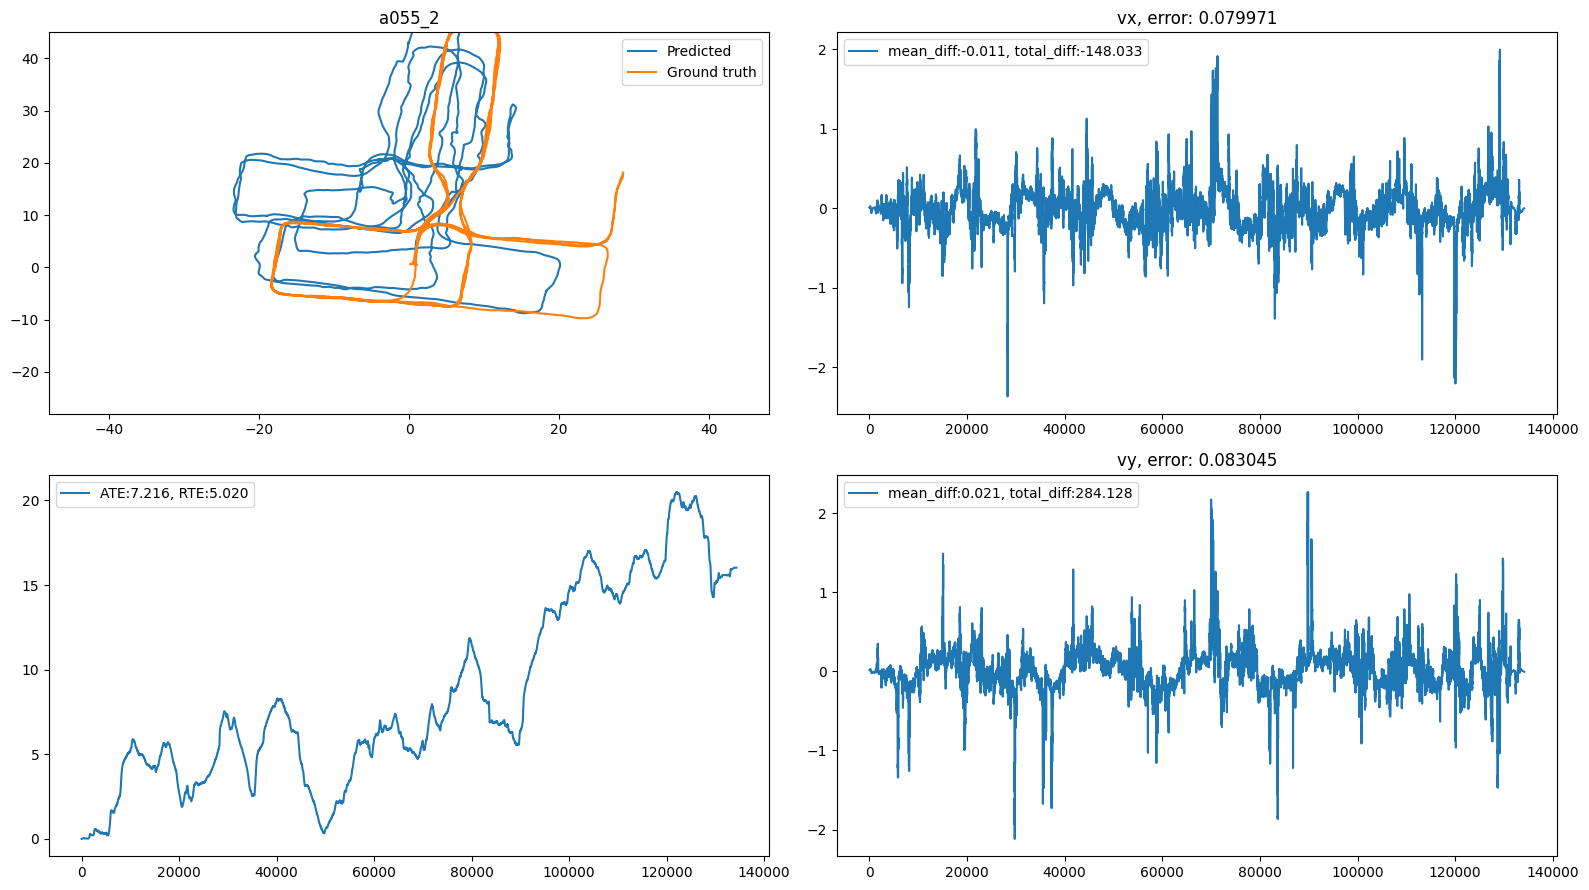

a055_3: device: asus3, ori_error (game_rv): 4.760
Sequence a055_3, loss [0.091392 0.093624] / 0.0925079882144928, ate 8.786924, rte 5.295276
length of predictions:  13735
length of predictions:  13735


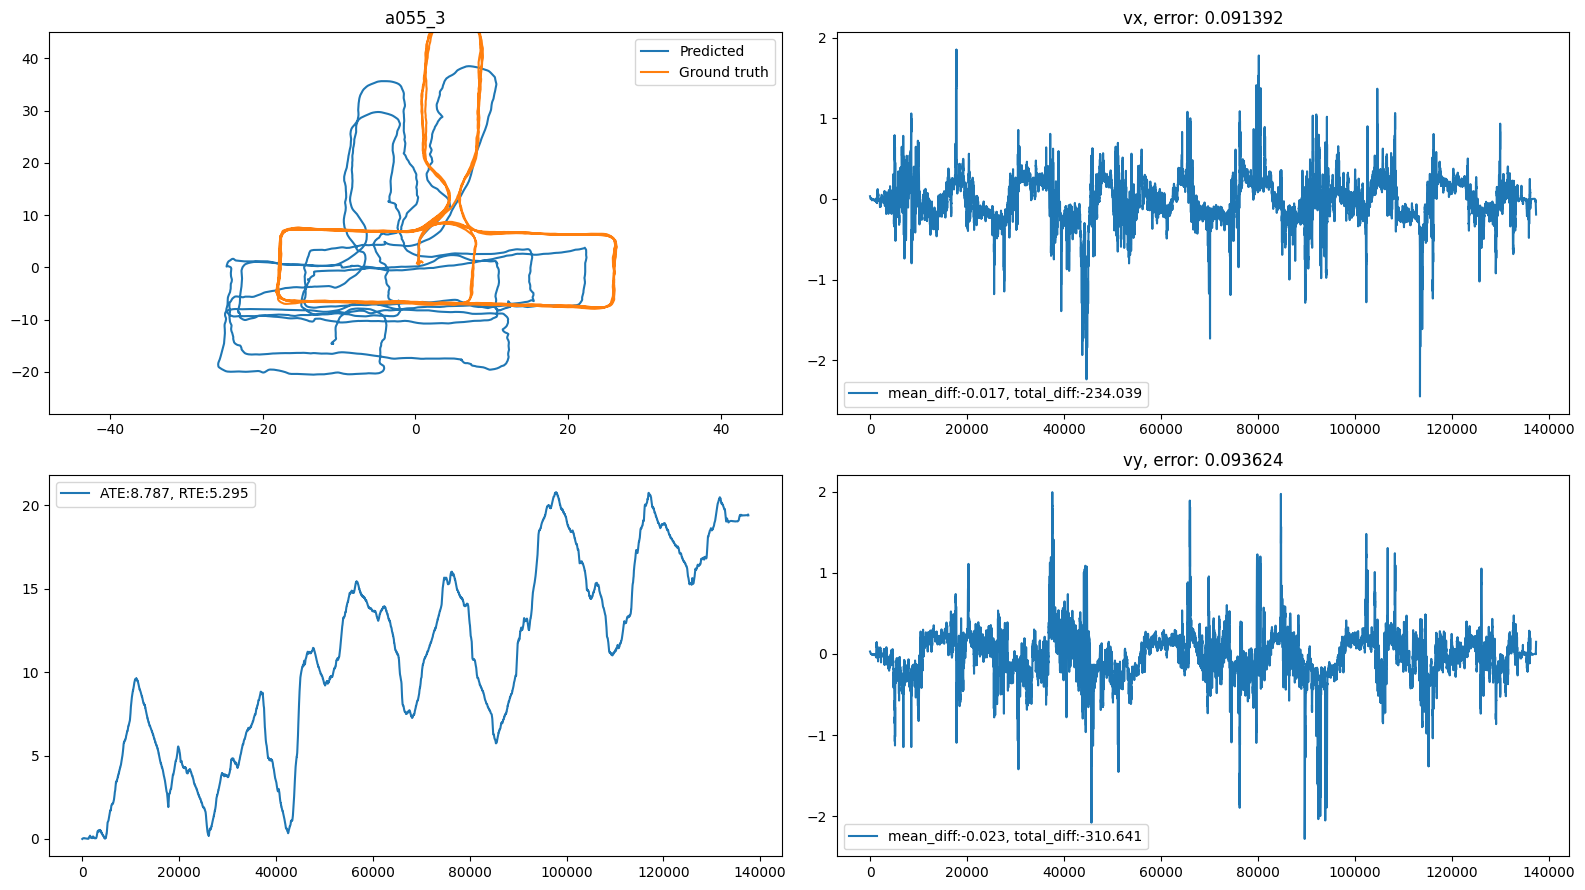

a057_1: device: samsung1, ori_error (game_rv): 24.549
Sequence a057_1, loss [0.089978 0.074229] / 0.08210356533527374, ate 7.276440, rte 8.009523
length of predictions:  10610
length of predictions:  10610


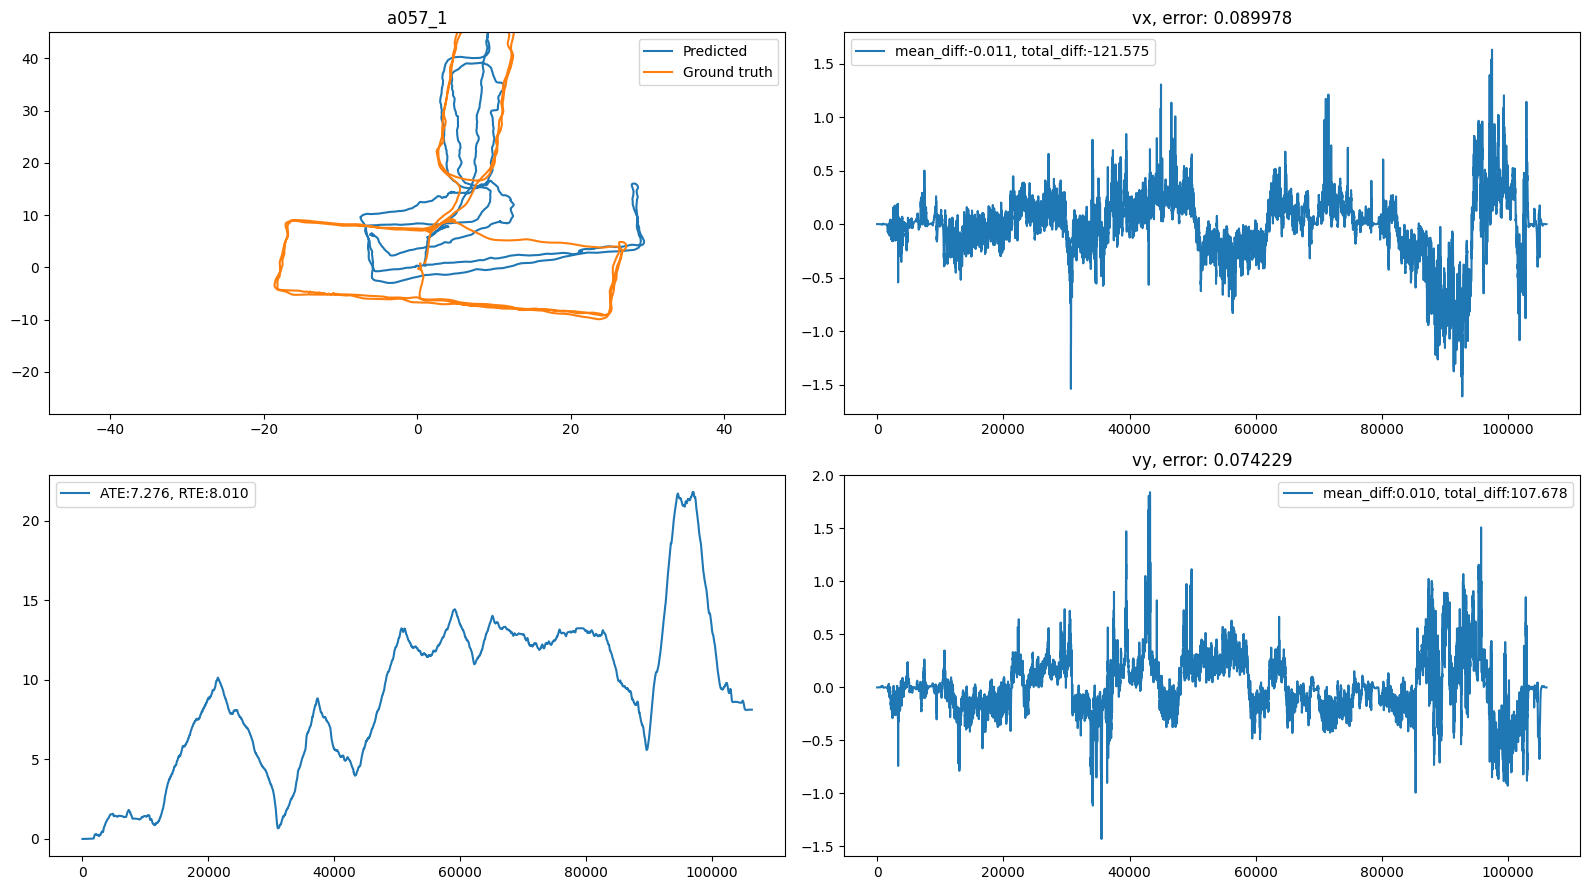

a057_2: device: samsung1, ori_error (game_rv): 1.853
Sequence a057_2, loss [0.032747 0.031517] / 0.03213193640112877, ate 4.591119, rte 3.137032
length of predictions:  13524
length of predictions:  13524


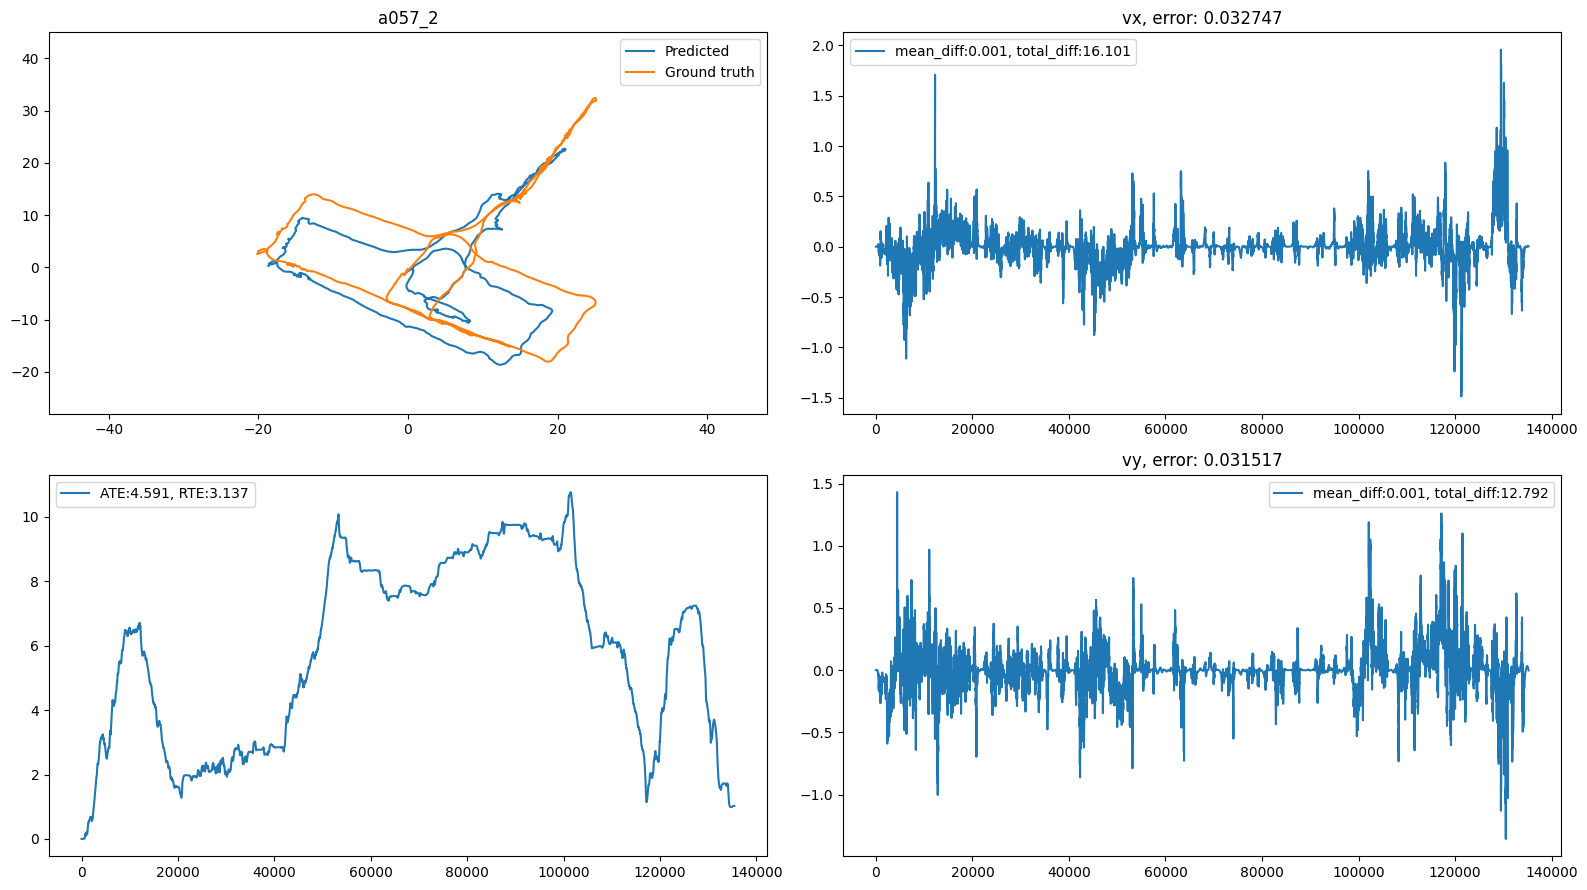

a057_3: device: samsung1, ori_error (game_rv): 6.956
Sequence a057_3, loss [0.045873 0.044336] / 0.04510413482785225, ate 9.998278, rte 4.666117
length of predictions:  12000
length of predictions:  12000


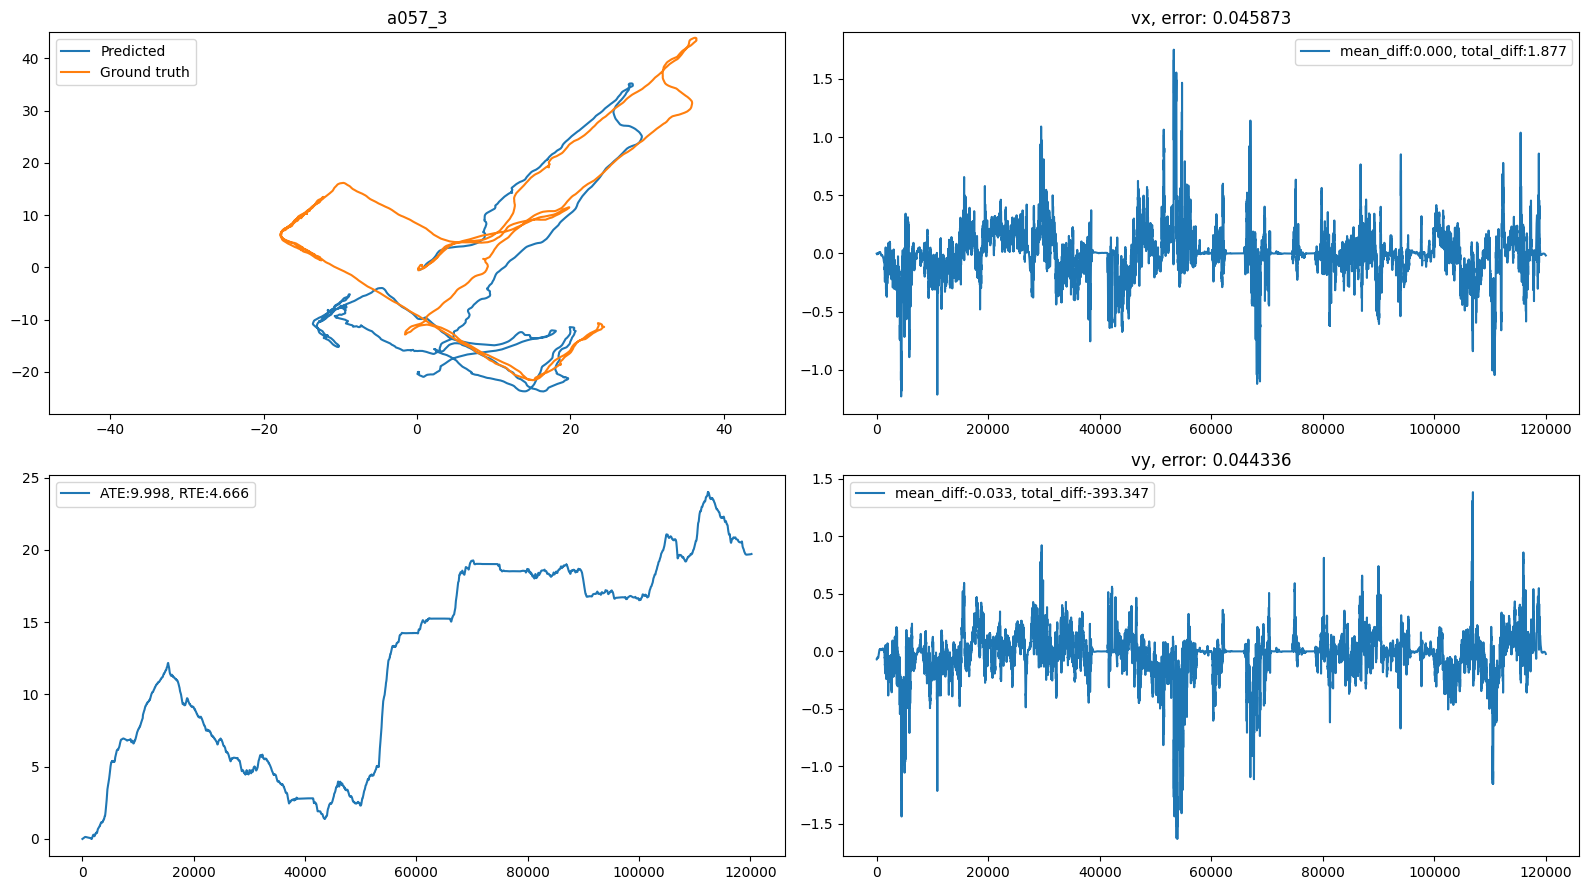

a058_1: device: asus4, ori_error (game_rv): 31.679
Sequence a058_1, loss [0.111947 0.025584] / 0.06876581162214279, ate 4.595408, rte 8.807840
length of predictions:  7895
length of predictions:  7895


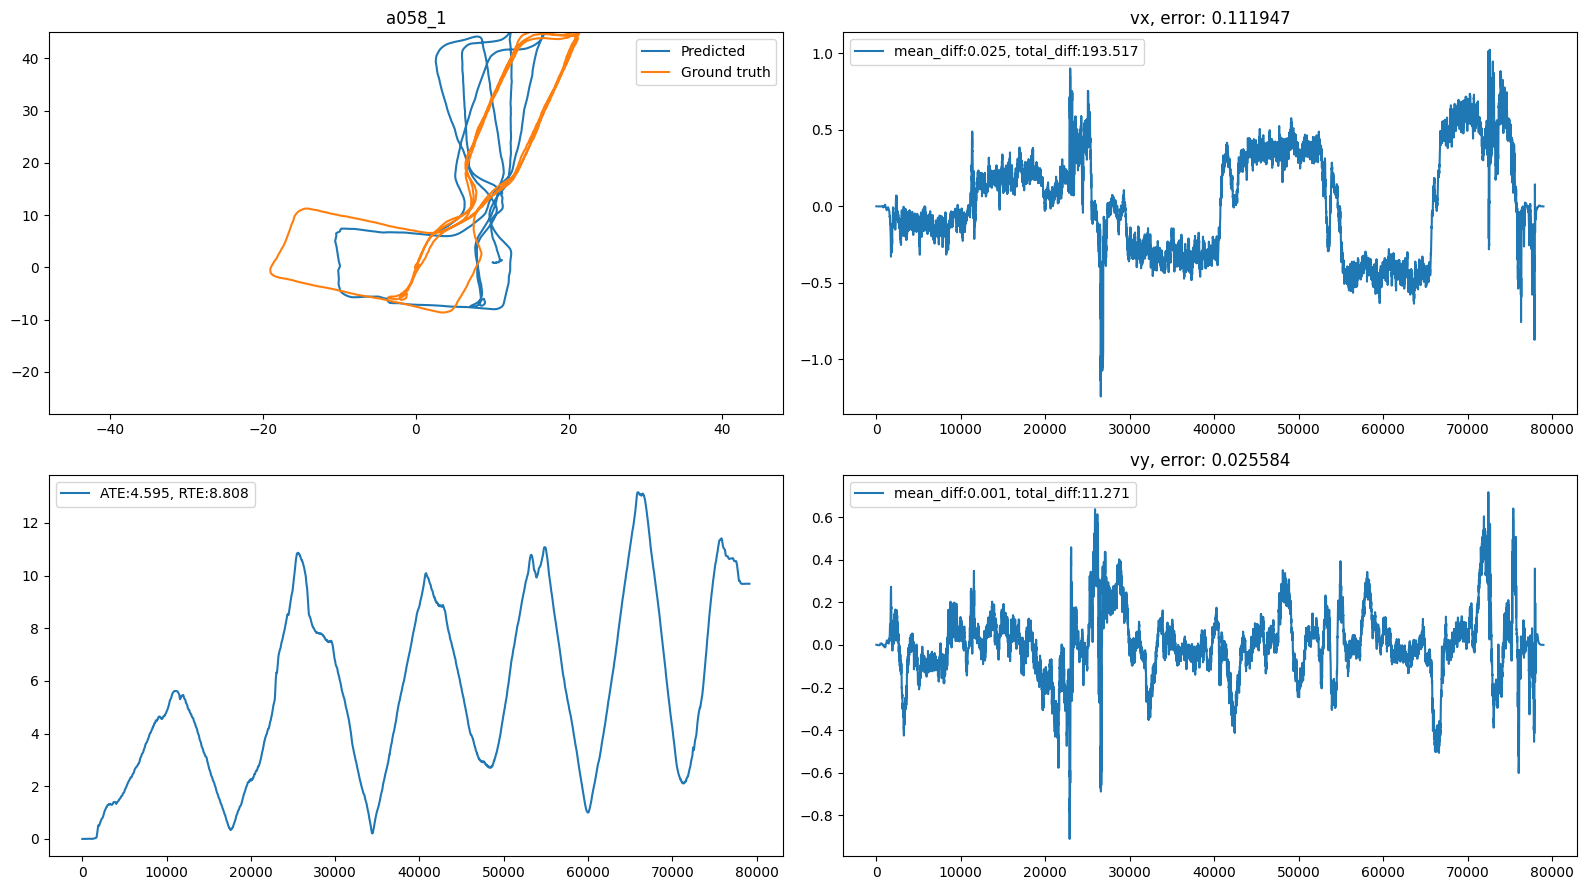

a058_2: device: asus4, ori_error (game_rv): 9.231
Sequence a058_2, loss [0.008824 0.011770] / 0.010296853259205818, ate 2.377448, rte 2.942965
length of predictions:  13234
length of predictions:  13234


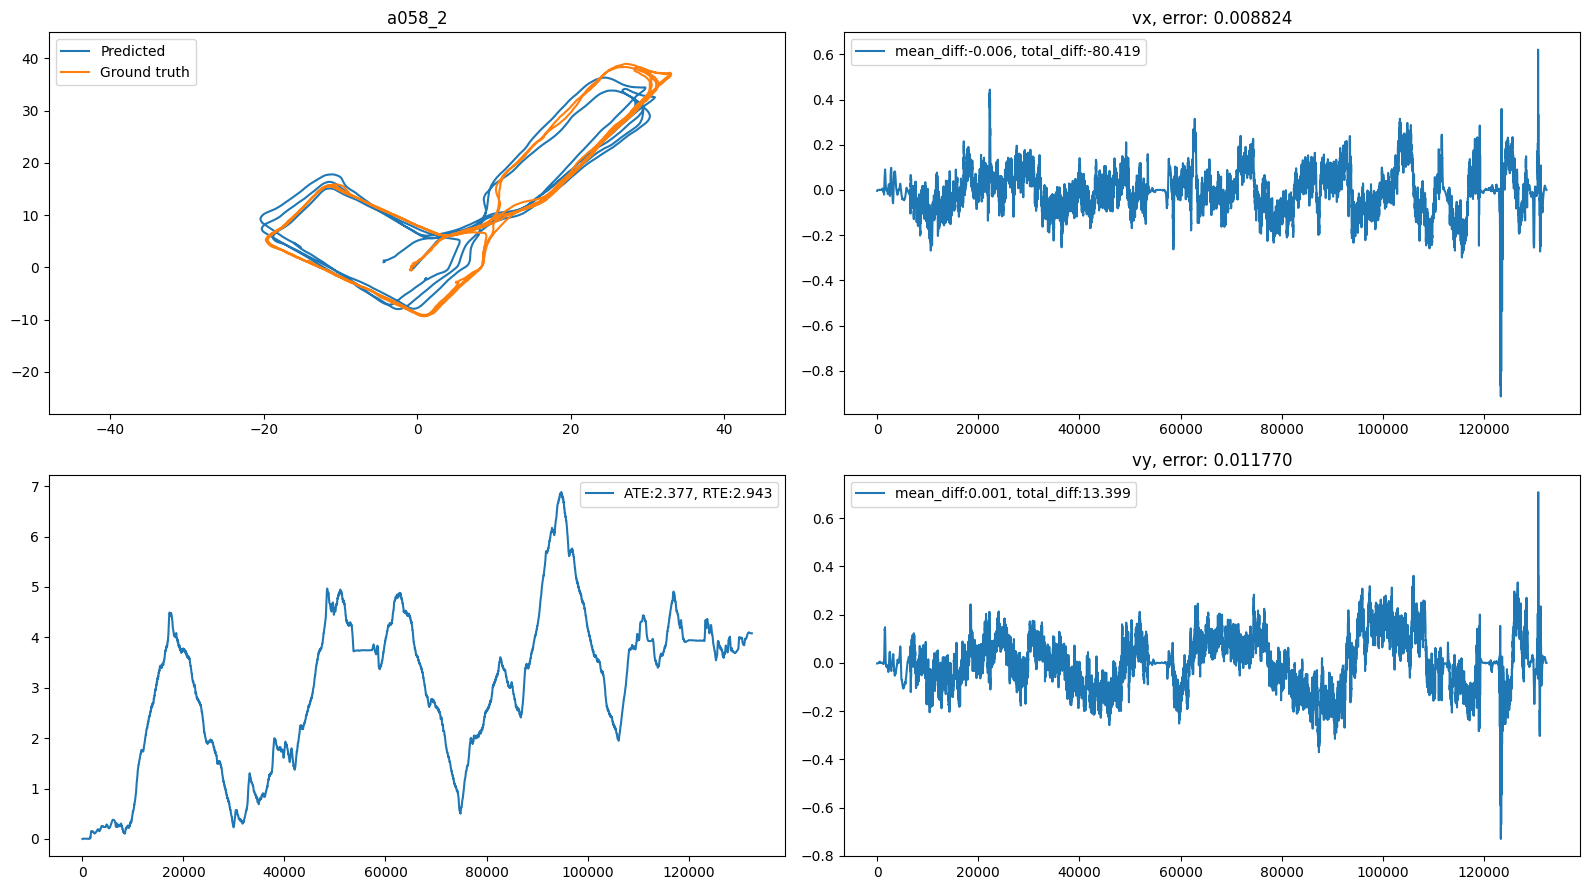

a058_3: device: asus4, ori_error (game_rv): 9.122
Sequence a058_3, loss [0.031657 0.043529] / 0.03759291023015976, ate 2.860267, rte 4.517720
length of predictions:  13020
length of predictions:  13020


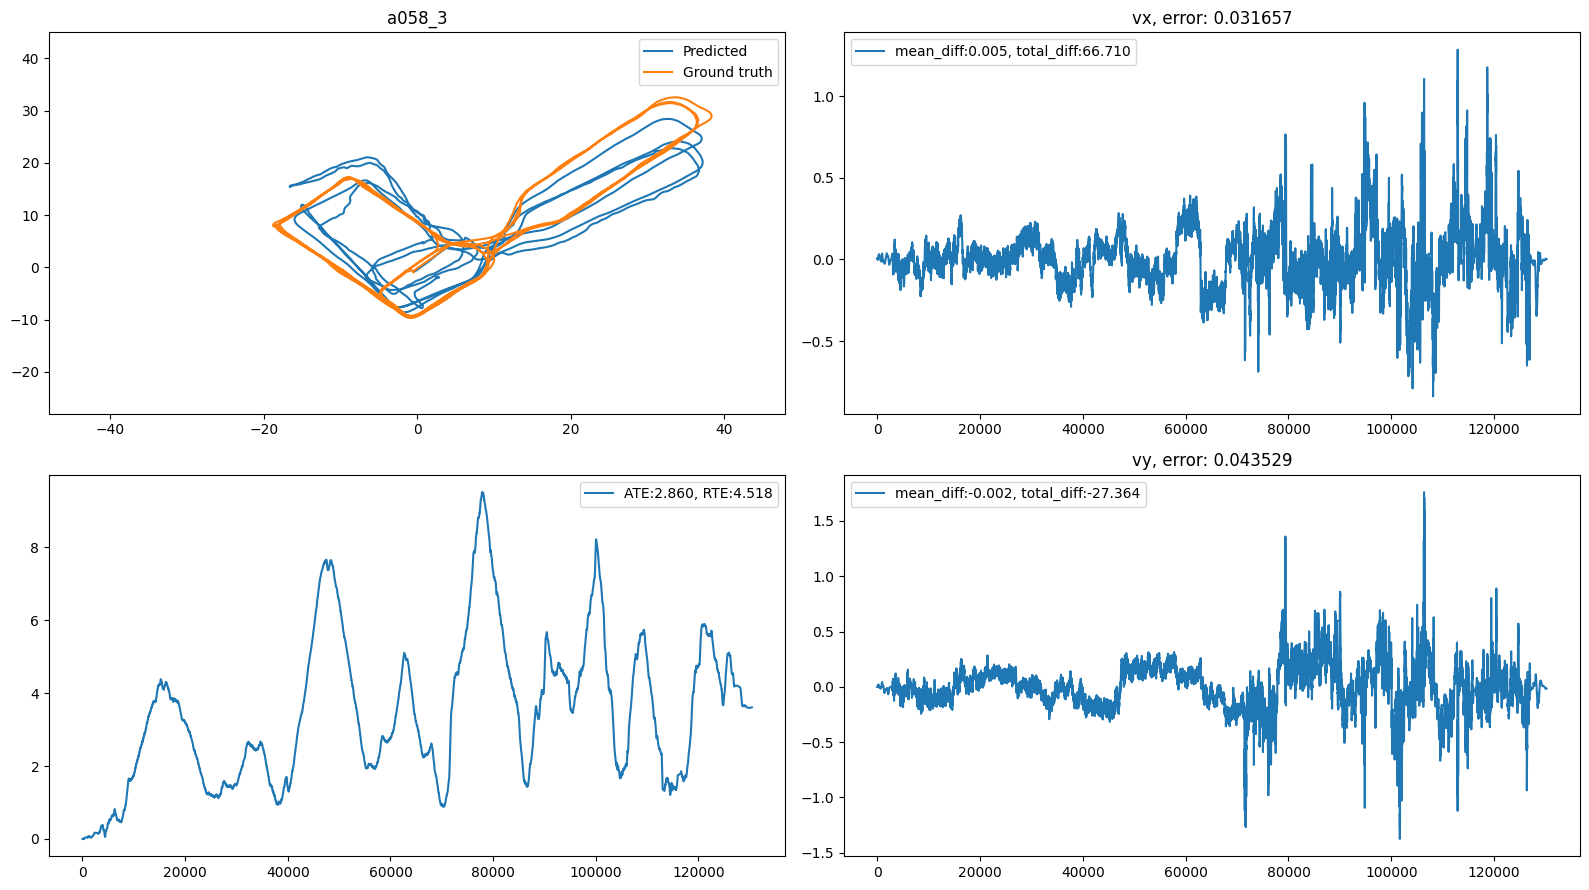

----------
Overall loss: [0.044554 0.040079]/0.0423167459666729, avg ATE:5.13997065907331, avg RTE:4.376960216498336


array([0.015519, 0.056720, 0.055919, 0.028202, 0.078776, 0.010959,
       0.027173, 0.099485, 0.039170, 0.059925, 0.015079, 0.013142,
       0.049805, 0.082833, 0.035626, 0.009128, 0.014696, 0.089507,
       0.020738, 0.010590, 0.009842, 0.031123, 0.016673, 0.033492,
       0.081508, 0.092508, 0.082104, 0.032132, 0.045104, 0.068766,
       0.010297, 0.037593], dtype=float32)

In [27]:
args.step_size = 100
test_sequence(args)

In [ ]:
train(args)